In [ ]:
#| eval: false
! [ -e /content ] && pip install -Uqq xcube # upgrade xcube on colab

In [ ]:
from fastai.text.all import *
from xcube.text.all import *
from fastai.metrics import accuracy # there's an 'accuracy' metric in xcube as well (Deb fix name conflict later)  

Make sure we have that "beast":

In [ ]:
#| eval: false
ic(torch.cuda.get_device_name(default_device()));
test_eq(torch.cuda.get_device_name(0), torch.cuda.get_device_name(default_device()))
test_eq(default_device(), torch.device(0))
print(f"GPU memory = {torch.cuda.get_device_properties(default_device()).total_memory/1024**3}GB")

ic| torch.cuda.get_device_name(default_device()): 'Quadro RTX 8000'


GPU memory = 44.99969482421875GB


In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

In [ ]:
source = untar_xxx(XURLs.MIMIC3)
source_l2r = untar_xxx(XURLs.MIMIC3_L2R)

Setting some environment variables:

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

Setting defaults for pandas and matplotlib:

In [ ]:
# Set the default figure size
plt.rcParams["figure.figsize"] = (8, 4)

Altering some default jupyter settings:

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "last" # "all"

# Training an XML Text Classifier

## `DataLoaders` for the Language Model

To be able to use Transfer Learning, first we need to fine-tune our Language Model (which we pretrained on Wikipedia) on the corpus of Wiki-500k (the one we downloaded). Here we will build the `DataLoaders` object using fastai's `DataBlock` API:

In [ ]:
data = source/'mimic3-9k.csv'
!head -n 1 {data}

subject_id,hadm_id,text,labels,length,is_valid


In [ ]:
df = pd.read_csv(data,
                 header=0,
                 names=['subject_id', 'hadm_id', 'text', 'labels', 'length', 'is_valid'],
                 dtype={'subject_id': str, 'hadm_id': str, 'text': str, 'labels': str, 'length': np.int64, 'is_valid': bool})
len(df)

52726

In [ ]:
df[['text', 'labels']] = df[['text', 'labels']].astype(str)

Let's take a look at the data:

In [ ]:
df.head(3)

,subject_id,hadm_id,text,labels,length,is_valid
0,86006,111912,admission date discharge date date of birth sex f service surgery allergies patient recorded as having no known allergies to drugs attending first name3 lf chief complaint 60f on coumadin was found slightly drowsy tonight then fell down stairs paramedic found her unconscious and she was intubated w o any medication head ct shows multiple iph transferred to hospital1 for further eval major surgical or invasive procedure none past medical history her medical history is significant for hypertension osteoarthritis involving bilateral knee joints with a dependence on cane for ambulation chronic...,801.35;348.4;805.06;807.01;998.30;707.24;E880.9;427.31;414.01;401.9;V58.61;V43.64;707.00;E878.1;96.71,230,False
1,85950,189769,admission date discharge date service neurosurgery allergies sulfa sulfonamides attending first name3 lf chief complaint cc cc contact info major surgical or invasive procedure none history of present illness hpi 88m who lives with family had fall yesterday today had decline in mental status ems called pt was unresponsive on arrival went to osh head ct showed large r sdh pt was intubated at osh and transferred to hospital1 for further care past medical history cad s p mi in s p cabg in ventricular aneurysm at that time cath in with occluded rca unable to intervene chf reported ef 1st degre...,852.25;E888.9;403.90;585.9;250.00;414.00;V45.81;96.71,304,False
2,88025,180431,admission date discharge date date of birth sex f service surgery allergies no known allergies adverse drug reactions attending first name3 lf chief complaint s p fall major surgical or invasive procedure none history of present illness 45f etoh s p fall from window at feet found ambulating and slurring speech on scene intubated en route for declining mental status in the er the patient was found to be bradycardic to the s with bp of systolic she was given atropine dilantin and was started on saline past medical history unknown social history unknown family history unknown physical exam ex...,518.81;348.4;348.82;801.25;427.89;E882;V49.86;305.00;96.71;38.93,359,False


We will now create the `DataLoaders` using `DataBlock` API:

In [ ]:
dls_lm = DataBlock(
    blocks   = TextBlock.from_df('text', is_lm=True),
    get_x    = ColReader('text'),
    splitter = RandomSplitter(0.1)
).dataloaders(df, bs=384, seq_len=80)

For the backward LM:

In [ ]:
dls_lm_r = DataBlock(
    blocks   = TextBlock.from_df('text', is_lm=True, backwards=True),
    get_x    = ColReader('text'),
    splitter = RandomSplitter(0.1)
).dataloaders(df, bs=384, seq_len=80)

Let's take a look at the batches:

In [ ]:
dls_lm.show_batch(max_n=2)

,text,text_
0,xxbos admission date discharge date date of birth sex m history of present illness first name8 namepattern2 known lastname is the firstborn of triplets at week gestation born to a year old gravida para woman immune rpr non reactive hepatitis b surface antigen negative group beta strep status unknown this was an intrauterine insemination achieved pregnancy the pregnancy was uncomplicated until when mother was admitted for evaluation of pregnancy induced hypertension she was treated with betamethasone and discharged home she,admission date discharge date date of birth sex m history of present illness first name8 namepattern2 known lastname is the firstborn of triplets at week gestation born to a year old gravida para woman immune rpr non reactive hepatitis b surface antigen negative group beta strep status unknown this was an intrauterine insemination achieved pregnancy the pregnancy was uncomplicated until when mother was admitted for evaluation of pregnancy induced hypertension she was treated with betamethasone and discharged home she was
1,occluded rca with l to r collaterals the femoral sheath was sewn in started on heparin and transferred to hospital1 for surgical revascularization past medical history coronary artery diease s p myocardial infarction s p pci to rca subarachnoid hemorrhage secondary to streptokinase hypertension hyperlipidemia hiatal hernia gastritis depression reactive airway disease s p ppm placement for 2nd degree av block social history history of smoking having quit in with a pack year history family history strong family history of,rca with l to r collaterals the femoral sheath was sewn in started on heparin and transferred to hospital1 for surgical revascularization past medical history coronary artery diease s p myocardial infarction s p pci to rca subarachnoid hemorrhage secondary to streptokinase hypertension hyperlipidemia hiatal hernia gastritis depression reactive airway disease s p ppm placement for 2nd degree av block social history history of smoking having quit in with a pack year history family history strong family history of premature


In [ ]:
dls_lm_r.show_batch(max_n=2)

,text,text_
0,sb west d i basement name first doctor bldg name ward hospital lm lf name3 first lf name last name last doctor d i 30a visit fellow sb west d i name first doctor name last doctor d i 30p visit attending opat appointments up follow disease infectious garage name ward hospital parking best east campus un location ctr clinical name ward hospital sc building fax telephone md namepattern4 name last pattern1 name name11 first with am at wednesday when,west d i basement name first doctor bldg name ward hospital lm lf name3 first lf name last name last doctor d i 30a visit fellow sb west d i name first doctor name last doctor d i 30p visit attending opat appointments up follow disease infectious garage name ward hospital parking best east campus un location ctr clinical name ward hospital sc building fax telephone md namepattern4 name last pattern1 name name11 first with am at wednesday when services
1,bare and catheterization cardiac a for hospital1 to flown were you infarction myocardial or attack heart a and pain chest had you instructions discharge independent ambulatory status activity interactive and alert consciousness of level coherent and clear status mental condition discharge hyperglycemia hyperlipidemia hypertension infarction myocardial inferior acute diagnosis discharge home disposition discharge refills tablets disp pain chest for needed as year month of total a for minutes every sublingual tablet one sig sublingual tablet mg nitroglycerin day a once,and catheterization cardiac a for hospital1 to flown were you infarction myocardial or attack heart a and pain chest had you instructions discharge independent ambulatory status activity interactive and alert consciousness of level coherent and clear status mental condition discharge hyperglycemia hyperlipidemia hypertension infarction myocardial inferior acute diagnosis discharge home disposition discharge refills tablets disp pain chest for needed as year month of total a for minutes every sublingual tablet one sig sublingual tablet mg nitroglycerin day a once po


The length of our vocabulary is:

In [ ]:
len(dls_lm.vocab)

57376

Let's take a look at some words of the vocab:

In [ ]:
print(coll_repr(L(dls_lm.vocab), 30))

(#57376) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj','the','and','to','of','was','with','a','on','in','for','mg','no','tablet','patient','is','he','at','blood','name','po','she'...]


Creating the `DataLaoders` takes some time, so smash that *save* button (also a good idea to save the `dls_lm.vocab` for later use) if you are working on your own dataset. In this case though `untar_xxx` has got it for you:

In [ ]:
print("\n".join(L(source.glob("**/*dls*lm*.pkl")).map(str))) # the ones with _r are for the reverse language model

/home/deb/.xcube/data/mimic3/mimic3-9k_dls_lm.pkl
/home/deb/.xcube/data/mimic3/mimic3-9k_dls_lm_vocab_r.pkl
/home/deb/.xcube/data/mimic3/mimic3-9k_dls_lm_vocab.pkl
/home/deb/.xcube/data/mimic3/mimic3-9k_dls_lm_r.pkl
/home/deb/.xcube/data/mimic3/mimic3-9k_dls_lm_old.pkl


To load back the `dls_lm` later on:

In [ ]:
dls_lm = torch.load(source/'mimic3-9k_dls_lm.pkl')

In [ ]:
dls_lm_r = torch.load(source/'mimic3-9k_dls_lm_r.pkl')

## `Learner` for the Language Model Fine-Tuning:

In [ ]:
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3,
    metrics=[accuracy, Perplexity()]).to_fp16()

And, one more for the reverse:

In [ ]:
learn_r = language_model_learner(
    dls_lm_r, AWD_LSTM, drop_mult=0.3, backwards=True,
    metrics=[accuracy, Perplexity()]).to_fp16()

Training a language model on the full datset takes a lot of time. So you can train one on a tiny dataset for illustration. Or you can skip the training and just load up the one that's pretrained and downloaded by `untar_xxx` and just do the validation.

Let's compute the learning rate using the `lr_find`:

In [ ]:
lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lr_min, lr_steep, lr_valley, lr_slide

In [ ]:
learn.fit_one_cycle(1, lr_min)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.646323,3.512013,0.382642,33.515659,2:27:57


It takes quite a while to train each epoch, so we'll be saving the intermediate model results during the training process:

Since we have completed the initial training, we will now continue fine-tuning the model after unfreezing:

In [ ]:
learn.unfreeze()

and run `lr_find` again, because we now have more layers to train, and the last layers weight have already been trained for one epoch:

In [ ]:
lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lr_min, lr_steep, lr_valley, lr_slide

Let's now traing with a suitable learning rate:

In [ ]:
learn.fit(15, lr=1e-5, cbs=SaveModelCallback(fname='lm_now'))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.146188,2.057686,0.567773,7.827838,50:52
1,2.128464,2.056832,0.567727,7.821152,50:22
2,2.130863,2.056411,0.567697,7.817858,50:45
3,2.145324,2.056166,0.567647,7.815949,48:14
4,2.150917,2.055998,0.567635,7.814632,48:28
5,2.140279,2.055952,0.567605,7.814274,50:48
6,2.142321,2.055915,0.567604,7.813985,49:01
7,2.134698,2.055936,0.567555,7.814146,48:28
8,2.128352,2.055983,0.567532,7.814515,49:07
9,2.139955,2.056035,0.567506,7.814924,47:08


Better model found at epoch 0 with valid_loss value: 2.0576863288879395.
Better model found at epoch 1 with valid_loss value: 2.0568318367004395.
Better model found at epoch 2 with valid_loss value: 2.056410551071167.
Better model found at epoch 3 with valid_loss value: 2.056166410446167.
Better model found at epoch 4 with valid_loss value: 2.055997848510742.
Better model found at epoch 5 with valid_loss value: 2.0559520721435547.
Better model found at epoch 6 with valid_loss value: 2.055915117263794.


Reverse

In [ ]:
learn_r.unfreeze()

In [ ]:
learn_r.fit(20, lr=1e-5, cbs=SaveModelCallback(fname='lm_r_now'))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.212396,2.099074,0.569185,8.158612,51:08
1,2.212062,2.098635,0.569127,8.155032,50:51
2,2.199151,2.098516,0.569043,8.154062,48:13
3,2.204254,2.098572,0.568977,8.154521,51:45
4,2.194751,2.098720,0.568967,8.155726,51:58
5,2.191622,2.098872,0.568894,8.156965,51:55
6,2.193636,2.099078,0.568827,8.158648,50:18
7,2.187115,2.099302,0.568777,8.160474,50:20
8,2.196913,2.099486,0.568725,8.161975,50:25
9,2.197563,2.099737,0.568679,8.164021,49:59


Better model found at epoch 0 with valid_loss value: 2.099074125289917.
Better model found at epoch 1 with valid_loss value: 2.098635196685791.
Better model found at epoch 2 with valid_loss value: 2.0985162258148193.


Note: Make sure if you have trained the most recent language model `Learner` for more epochs (then you need to save that version)

Here you can load the pretrained language model which `untar_xxx` downloaded:

In [ ]:
learn = learn.load(source/'mimic3-9k_lm')

In [ ]:
learn_r = learn_r.load(source/'mimic3-9k_lm_r')

Let's validate the `Learner` to make sure we loaded the correct version:

In [ ]:
learn.validate()

(#3) [2.060459852218628,0.5676611661911011,7.849578857421875]

and the reverse...

In [ ]:
learn_r.validate()

(#3) [2.101907968521118,0.5691556334495544,8.18176555633545]

### Saving the encoder of the Language Model

**Crucial:** Once we have trained our LM we will save all of our model except the final layer that converts activation to probabilities of picking each token in our vocabulary. The model not including the final layer has a sexy name - *encoder*. We will save it using `save_encoder` method of the `Learner`:

In [ ]:
# learn.save_encoder('lm_finetuned')
# learn_r.save_encoder('lm_finetuned_r')

### Saving the decoder of the Language Model

In [ ]:
learn.save_decoder('mimic3-9k_lm_decoder')
learn_r.save_decoder('mimic3-9k_lm_decoder_r')

This completes the second stage of the text classification process - fine-tuning the Language Model pretrained on Wikipedia corpus. We will now use it to fine-tune a text multi-label text classifier.

## `DataLoaders` for the MIMIC3-Full Multi-Label Classifier (using fastai's Mid-Level Data API)

Fastai's midlevel data api is the swiss army knife of data preprocessing. Detailed tutorials can be found here [intermediate](https://docs.fast.ai/tutorial.pets.html), [advanced](https://docs.fast.ai/tutorial.siamese.html). We will use it here to create our dataloaders for the classifier. 

### Loading Raw Data

In [ ]:
data = source/'mimic3-9k.csv'
!head -n 1 {data}

subject_id,hadm_id,text,labels,length,is_valid


In [ ]:
# !shuf -n 200000 {data} > {data_sample} 

In [ ]:
df = pd.read_csv(data,
                 header=0,
                 names=['subject_id', 'hadm_id', 'text', 'labels', 'length', 'is_valid'],
                 dtype={'subject_id': str, 'hadm_id': str, 'text': str, 'labels': str, 'length': np.int64, 'is_valid': bool})

In [ ]:
df[['text', 'labels']] = df[['text', 'labels']].astype(str)

In [ ]:
df.head(3)

,subject_id,hadm_id,text,labels,length,is_valid
0,86006,111912,admission date discharge date date of birth sex f service surgery allergies patient recorded as having no known allergies to drugs attending first name3 lf chief complaint 60f on coumadin was found slightly drowsy tonight then fell down stairs paramedic found her unconscious and she was intubated w o any medication head ct shows multiple iph transferred to hospital1 for further eval major surgical or invasive procedure none past medical history her medical history is significant for hypertension osteoarthritis involving bilateral knee joints with a dependence on cane for ambulation chronic...,801.35;348.4;805.06;807.01;998.30;707.24;E880.9;427.31;414.01;401.9;V58.61;V43.64;707.00;E878.1;96.71,230,False
1,85950,189769,admission date discharge date service neurosurgery allergies sulfa sulfonamides attending first name3 lf chief complaint cc cc contact info major surgical or invasive procedure none history of present illness hpi 88m who lives with family had fall yesterday today had decline in mental status ems called pt was unresponsive on arrival went to osh head ct showed large r sdh pt was intubated at osh and transferred to hospital1 for further care past medical history cad s p mi in s p cabg in ventricular aneurysm at that time cath in with occluded rca unable to intervene chf reported ef 1st degre...,852.25;E888.9;403.90;585.9;250.00;414.00;V45.81;96.71,304,False
2,88025,180431,admission date discharge date date of birth sex f service surgery allergies no known allergies adverse drug reactions attending first name3 lf chief complaint s p fall major surgical or invasive procedure none history of present illness 45f etoh s p fall from window at feet found ambulating and slurring speech on scene intubated en route for declining mental status in the er the patient was found to be bradycardic to the s with bp of systolic she was given atropine dilantin and was started on saline past medical history unknown social history unknown family history unknown physical exam ex...,518.81;348.4;348.82;801.25;427.89;E882;V49.86;305.00;96.71;38.93,359,False


Sample a small fraction of the dataset to ensure quick iteration (Skip this if you want to do this on the full dataset)

In [ ]:
# df = df.sample(frac=0.3, random_state=89, ignore_index=True)
# df = df.sample(frac=0.025, random_state=89, ignore_index=True)
# df = df.sample(frac=0.005, random_state=89, ignore_index=True)
len(df)

52726

Let's now gather the labels from the 'labels' columns of the df:

In [ ]:
lbl_freqs = Counter()
for labels in df.labels: lbl_freqs.update(labels.split(';'))

The total number of labels are:

In [ ]:
len(lbl_freqs)

8922

Let's take a look at the most common labels:

In [ ]:
pd.DataFrame(lbl_freqs.most_common(50), columns=['label', 'frequency']).head()

,label,frequency
0,401.9,20053
1,38.93,14444
2,428.0,12842
3,427.31,12594
4,414.01,12179


Let's make a list of all labels (We will use it later while creating the `DataLoader`)

In [ ]:
lbls = L(lbl_freqs.most_common(50)).itemgot(0)

### Dataset Statistics (Optional) 
> Let's try to understand what captures the hardness of an xml dataset

#### Check #1: Number of instances (train/valid split)

In [ ]:
train, valid = df.index[~df['is_valid']], df.index[df['is_valid']]
len(train), len(valid)

(49354, 3372)

#### Check #2: Avg number of instances per label

In [ ]:
array(list(lbl_freqs.values())).mean()

95.12351490697154

#### Check #3: Plotting the label distribution

In [ ]:
lbl_count = []
for lbls in df.labels: lbl_count.append(len(lbls.split(';')))

In [ ]:
df_copy = df.copy()
df_copy['label_count'] = lbl_count

In [ ]:
df_copy.head(2)

,subject_id,hadm_id,text,labels,length,is_valid,label_count
0,86006,111912,admission date discharge date date of birth sex f service surgery allergies patient recorded as having no known allergies to drugs attending first name3 lf chief complaint 60f on coumadin was found slightly drowsy tonight then fell down stairs paramedic found her unconscious and she was intubated w o any medication head ct shows multiple iph transferred to hospital1 for further eval major surgical or invasive procedure none past medical history her medical history is significant for hypertension osteoarthritis involving bilateral knee joints with a dependence on cane for ambulation chronic...,801.35;348.4;805.06;807.01;998.30;707.24;E880.9;427.31;414.01;401.9;V58.61;V43.64;707.00;E878.1;96.71,230,False,15
1,85950,189769,admission date discharge date service neurosurgery allergies sulfa sulfonamides attending first name3 lf chief complaint cc cc contact info major surgical or invasive procedure none history of present illness hpi 88m who lives with family had fall yesterday today had decline in mental status ems called pt was unresponsive on arrival went to osh head ct showed large r sdh pt was intubated at osh and transferred to hospital1 for further care past medical history cad s p mi in s p cabg in ventricular aneurysm at that time cath in with occluded rca unable to intervene chf reported ef 1st degre...,852.25;E888.9;403.90;585.9;250.00;414.00;V45.81;96.71,304,False,8


The average number of labels per instance is:

In [ ]:
df_copy.label_count.mean()

16.096271289306983

/tmp/ipykernel_1132/31709751.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_copy.label_count, bins=10, color='b');


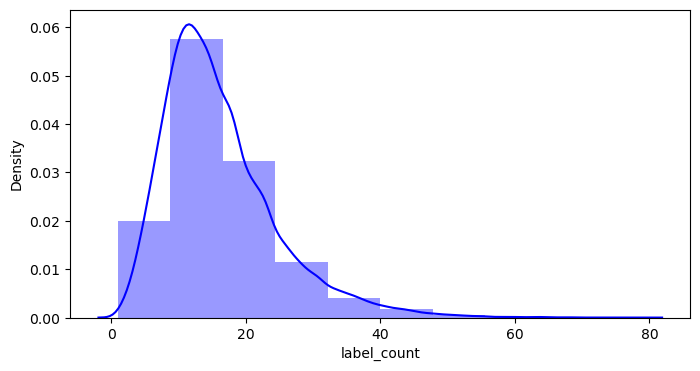

In [ ]:
import seaborn as sns
sns.distplot(df_copy.label_count, bins=10, color='b');

In [ ]:
lbls_sorted = sorted(lbl_freqs.items(), key=lambda item: item[1], reverse=True)

In [ ]:
lbls_sorted[:20]

[('401.9', 20053),
 ('38.93', 14444),
 ('428.0', 12842),
 ('427.31', 12594),
 ('414.01', 12179),
 ('96.04', 9932),
 ('96.6', 9161),
 ('584.9', 8907),
 ('250.00', 8784),
 ('96.71', 8619),
 ('272.4', 8504),
 ('518.81', 7249),
 ('99.04', 7147),
 ('39.61', 6809),
 ('599.0', 6442),
 ('530.81', 6156),
 ('96.72', 5926),
 ('272.0', 5766),
 ('285.9', 5296),
 ('88.56', 5240)]

In [ ]:
ranked_lbls = L(lbls_sorted).itemgot(0)
ranked_freqs = L(lbls_sorted).itemgot(1)
ranked_lbls, ranked_freqs

((#8922) ['401.9','38.93','428.0','427.31','414.01','96.04','96.6','584.9','250.00','96.71'...],
 (#8922) [20053,14444,12842,12594,12179,9932,9161,8907,8784,8619...])

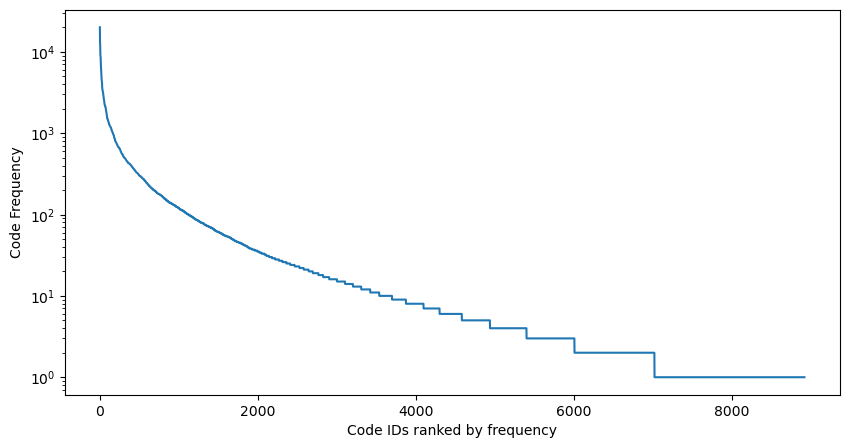

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.plot(ranked_freqs)
ax.set_xlabel('Code IDs ranked by frequency')
ax.set_ylabel('Code Frequency')
ax.set_yscale('log');
fig.savefig('icd9_lbs_skew.pdf')

#### Check #4: Computing the min label freq for each text

In [ ]:
df_copy.head(10)

,text,labels,is_valid,label_count,min_code_freq,max_code_freq,90pct_code_freq
0,"Methodical Bible study: A new approach to hermeneutics /SEP/ Methodical Bible study: A new approach to hermeneutics. Inductive study compares related Bible texts in order to let the Bible interpret itself, rather than approaching Scripture with predetermined notions of what it will say. Dr. Trainas Methodical Bible Study was not intended to be the last word in inductive Bible study; but since its first publication in 1952, it has become a foundational text in this field. Christian colleges and seminaries have made it required reading for beginning Bible students, while many churches have...","34141,119299,126600,128716,187372,218742",False,6,2,29,25.5
1,"Southeastern Mills Roast Beef Gravy Mix, 4.5-Ounce Packages (Pack of 24) /SEP/ Southeastern Mills Roast Beef Gravy Mix, 4.5-Ounce Packages (Pack of 24). Makes 3-1/2 cups. Down home taste. Makes hearty beef stew base.","465536,465553,615429",False,3,2,3,3.0
2,"MMF Industries 24-Key Portable Zippered Key Case (201502417) /SEP/ MMF Industries 24-Key Portable Zippered Key Case (201502417). The MMF Industries 201502417 24-Key Portable Zippered Key Case is an attractive burgundy-colored leather-like vinyl case with brass corners and looks like a portfolio. Its easy-slide zipper keeps keys enclosed, and a hook-and-loop fastener strips keep keys securely in place. Key tags are included.\tZippered key case offers a portable alternative to metal wall key cabinets. Included key tags are backed by hook-and-loop closures. Easy slide zipper keeps keys enclos...",393828,False,1,2,2,2.0
3,"Hoover the Fishing President /SEP/ Hoover the Fishing President. Hal Elliott Wert has spent years researching Herbert Hoover, Franklin Roosevelt, and Harry Truman. He holds a Ph.D. from the University of Kansas and currently teaches at the Kansas City Art Institute.","167614,223686",False,2,4,4,4.0
4,"GeoPuzzle U.S.A. and Canada - Educational Geography Jigsaw Puzzle (69 pcs) /SEP/ GeoPuzzle U.S.A. and Canada - Educational Geography Jigsaw Puzzle (69 pcs). GeoPuzzles are jigsaw puzzles that make learning world geography fun. The pieces of a GeoPuzzle are shaped like individual countries, so children learn as they put the puzzle together. Award-winning Geopuzzles help to build fine motor, cognitive, language, and problem-solving skills, and are a great introduction to world geography for children 4 and up. Designed by an art professor, jumbo sized and brightly colored GeoPuzzles are avail...","480528,480530,480532,485144,485146,598793",False,6,5,10,8.5
5,"Amazon.com: Paul Fredrick Men's Cotton Pinpoint Oxford Straight Collar Dress Shirt: Clothing /SEP/ Amazon.com: Paul Fredrick Men's Cotton Pinpoint Oxford Straight Collar Dress Shirt: Clothing. Pinpoint Oxford Cotton. Traditional Straight Collar, 1/4 Topstitched. Button Cuffs, 1/4 Topstitched. Embedded Collar Stay. Regular, Big and Tall. Top Center Placket. Split Yoke. Single Front Rounded Pocket. Machine Wash Or Dry Clean. Imported. * Big and Tall Sizes - addl $5.00","516790,567615,670034",False,3,256,1214,1141.2
6,"Darkest Fear : A Myron Bolitar Novel /SEP/ Darkest Fear : A Myron Bolitar Novel. Myron Bolitar's father's recent heart attack brings Myron smack into a midlife encounter with issues of adulthood and mortality. And if that's not enough to turn his life upside down, the reappearance of his first serious girlfriend is. The basketball star turned sports agent, who does a little detecting when business is slow, is saddened by the news that Emily Downing's 13-year-old son is dying and desperately needs a bone marrow transplant; even if she did leave him for the man who destroyed his basketball c...","50442,50516,50647,50672,50680,662538",False,6,2,3,2.5
7,"In Debt We Trust (2007) /SEP/ In Debt We Trust (2007). Just a few decades ago, owing more money than you had in your bank account was the exception, not the rule. Yet, in the last 10 years, consumer debt has doubled and,

In [ ]:
df_copy['min_code_freq'] = df_copy.apply(
    lambda row: min([lbl_freqs[lbl] for lbl in row.labels.split(',')]), axis=1)

In [ ]:
df_copy['max_code_freq'] = df_copy.apply(
    lambda row: max([lbl_freqs[lbl] for lbl in row.labels.split(',')]), axis=1)

In [ ]:
df_copy['90pct_code_freq'] = df_copy.apply(
    lambda row: np.percentile([lbl_freqs[lbl] for lbl in row.labels.split(',')], 90), axis=1)

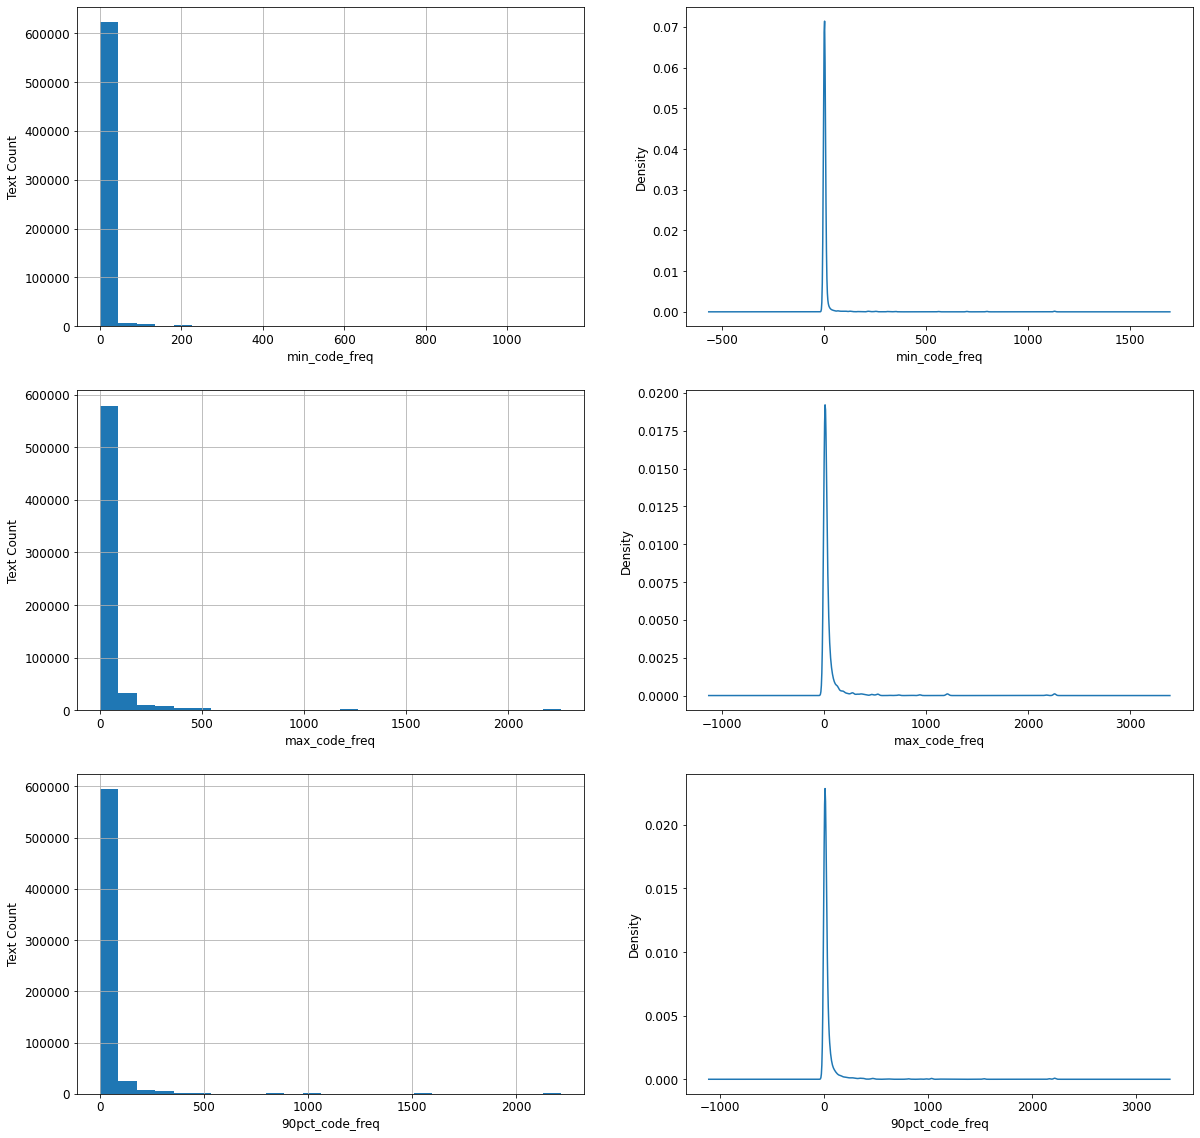

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,20))

for freq, axis in zip(['min_code_freq', 'max_code_freq', '90pct_code_freq'], axes):
    df_copy[freq].hist(ax=axis[0], bins=25)
    axis[0].set_xlabel(freq)
    axis[0].set_ylabel('Text Count')
    df_copy[freq].plot.density(ax=axis[1])
    axis[1].set_xlabel(freq)
    

In [ ]:
min_code_freqs = Counter(df_copy['min_code_freq'])
max_code_freqs = Counter(df_copy['max_code_freq'])
nintypct_code_freqs = Counter(df_copy['90pct_code_freq'])

In [ ]:
total_notes = L(min_code_freqs.values()).sum()
total_notes

643474

In [ ]:
for kmin in min_code_freqs:
    min_code_freqs[kmin] = (min_code_freqs[kmin]/total_notes) * 100
    
for kmax in max_code_freqs:
    max_code_freqs[kmax] = (max_code_freqs[kmax]/total_notes) * 100
    
for k90pct in nintypct_code_freqs:
    nintypct_code_freqs[k90pct] = (nintypct_code_freqs[k90pct]/total_notes) * 100

In [ ]:
min_code_freqs = dict(sorted(min_code_freqs.items(), key=lambda item: item[0]))
max_code_freqs = dict(sorted(max_code_freqs.items(), key=lambda item: item[0]))
nintypct_code_freqs = dict(sorted(nintypct_code_freqs.items(), key=lambda item: item[0]))

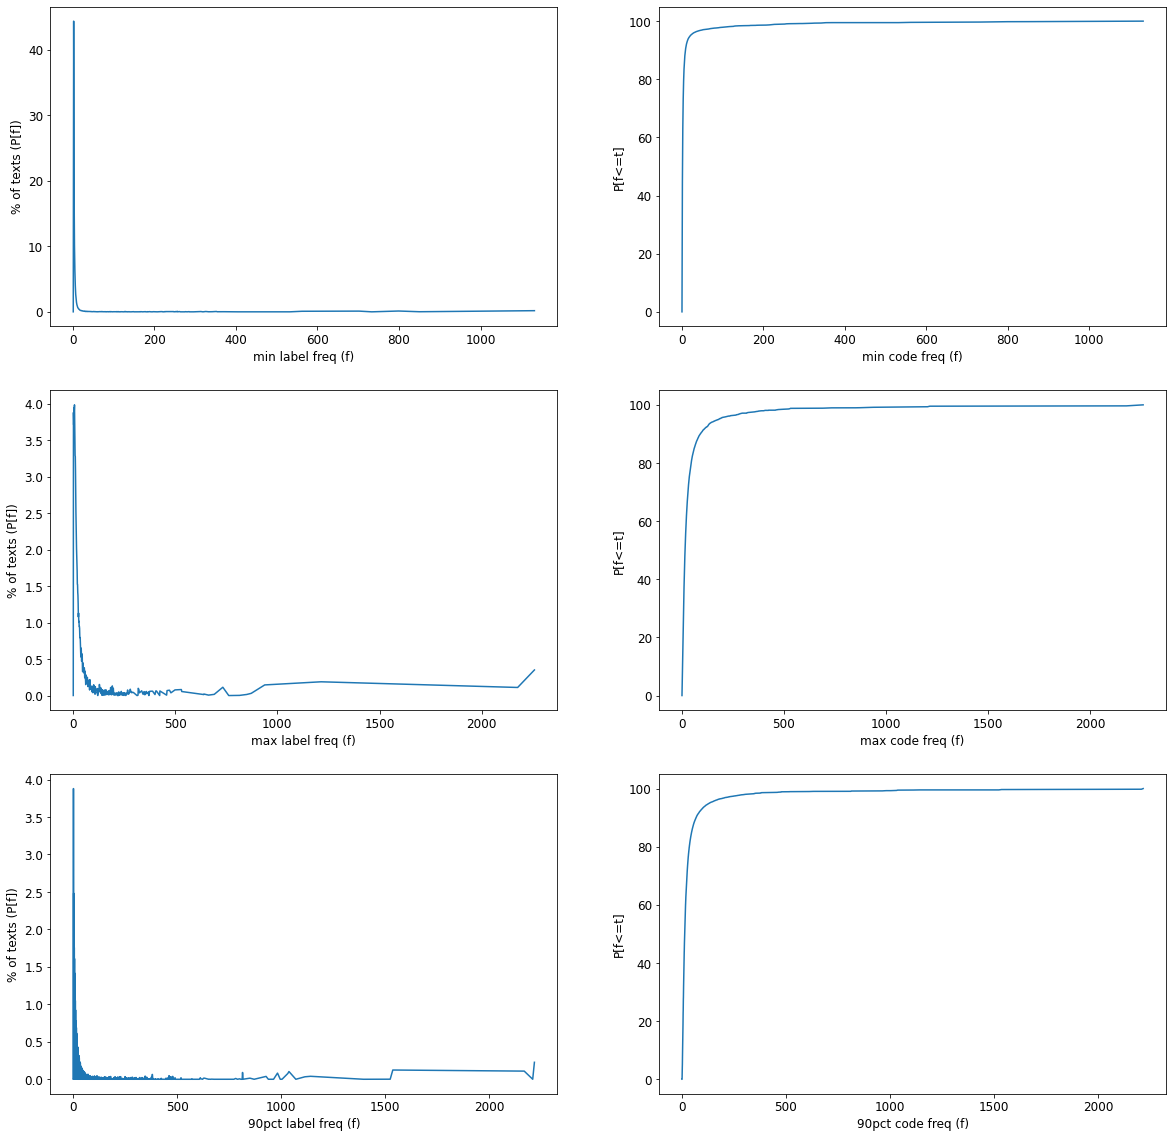

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,20))

for axis, freq_dict, label in zip(axes, (min_code_freqs, max_code_freqs, nintypct_code_freqs), ('min', 'max', '90pct')):
    axis[0].plot(freq_dict.keys(), freq_dict.values())
    axis[0].set_xlabel(f"{label} label freq (f)")
    axis[0].set_ylabel("% of texts (P[f])");
    
    axis[1].plot(freq_dict.keys(), np.cumsum(list(freq_dict.values())))
    axis[1].set_xlabel(f"{label} code freq (f)")
    axis[1].set_ylabel("P[f<=t]");

### Steps for creating the classifier `DataLoaders` using fastai's `Transforms`:

#### 1. train/valid `splitter`:

Okay, based on the `is_valid` column of our Dataframe, let's create a splitter:

In [ ]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].to_list()
    return train, valid

Let's check the train/valid split

In [ ]:
splits = [train, valid] = splitter(df)
L(splits[0]), L(splits[1])

((#49354) [0,1,2,3,4,5,6,7,8,9...],
 (#3372) [1631,1632,1633,1634,1635,1636,1637,1638,1639,1640...])

#### 2. Making the `Datasets` object:

**Crucial:** We need the vocab of the language model so that we can make sure we use the same correspondence of token to index. Otherwise, the embeddings we learned in our fine-tuned language model won't make any sense to our classifier model, and the fine-tuning won't be of any use. So we need to pass the `lm_vocab` to the `Numericalize` transform:

So let's load the vocab of the language model:

In [ ]:
lm_vocab = torch.load(source/'mimic3-9k_dls_lm_vocab.pkl')
lm_vocab_r = torch.load(source/'mimic3-9k_dls_lm_vocab_r.pkl')

In [ ]:
all_equal(lm_vocab, lm_vocab_r)
L(lm_vocab)

(#57376) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj','the'...]

In [ ]:
x_tfms = [Tokenizer.from_df('text'), attrgetter("text"), Numericalize(vocab=lm_vocab)]
x_tfms_r = [Tokenizer.from_df('text', ), attrgetter("text"), Numericalize(vocab=lm_vocab), reverse_text]
y_tfms = [ColReader('labels', label_delim=';'), MultiCategorize(vocab=lbls), OneHotEncode()]
tfms = [x_tfms, y_tfms]
tfms_r = [x_tfms_r, y_tfms]

In [ ]:
%%time
dsets = Datasets(df, tfms, splits=splits)

CPU times: user 17.9 s, sys: 3.27 s, total: 21.2 s
Wall time: 2min 38s


In [ ]:
%%time
dsets_r = Datasets(df, tfms_r, splits=splits)

CPU times: user 18.2 s, sys: 4.67 s, total: 22.9 s
Wall time: 2min 54s


Let's now check if our `Datasets` got created alright:

In [ ]:
len(dsets.train), len(dsets.valid)

(49354, 3372)

Let's check a random data point:

In [ ]:
idx = random.randint(0, len(dsets))
x = dsets.train[idx]
assert isinstance(x, tuple) # tuple if independent and dependent variable
x_r = dsets_r.train[idx]

In [ ]:
dsets.decode(x)

('xxbos admission date discharge date date of birth sex f service medicine allergies nsaids aspirin influenza virus vaccine attending first name3 lf chief complaint hypotension resp distress major surgical or invasive procedure rij placement and removal last name un gastric tube placement and removal rectal tube placement and removal picc line placement and removal history of present illness ms known lastname is a 50f with cirrhosis of unproven etiology h o perforated duodenal ulcer who has had weakness and back pain with cough and shortness of breath for days she has chronic low back pain but this is in a different location she also reports fever and chills she reports increasing weakness and fatigue over the same amount of time she is followed by vna who saw her at home and secondary to hypotension and hypoxia requested she go to ed in the ed initial vs were afebrile and o2 sat unable to be read ct of torso showed pneumonia but no abdominal pathology she was seen by surgery she was f

In [ ]:
dsets.show(x)

xxbos admission date discharge date date of birth sex f service medicine allergies nsaids aspirin influenza virus vaccine attending first name3 lf chief complaint hypotension resp distress major surgical or invasive procedure rij placement and removal last name un gastric tube placement and removal rectal tube placement and removal picc line placement and removal history of present illness ms known lastname is a 50f with cirrhosis of unproven etiology h o perforated duodenal ulcer who has had weakness and back pain with cough and shortness of breath for days she has chronic low back pain but this is in a different location she also reports fever and chills she reports increasing weakness and fatigue over the same amount of time she is followed by vna who saw her at home and secondary to hypotension and hypoxia requested she go to ed in the ed initial vs were afebrile and o2 sat unable to be read ct of torso showed pneumonia but no abdominal pathology she was seen by surgery she was fou

In [ ]:
assert isinstance(dsets.tfms[0], Pipeline) # `Pipeline` of the `x_tfms`
assert isinstance(dsets.tfms[0][0], Tokenizer)
assert isinstance(dsets.tfms[0][1], Transform)
assert isinstance(dsets.tfms[0][2], Numericalize)

If we just want to decode the one-hot encoded dependent variable:

In [ ]:
_ind, _dep = x
_lbl = dsets.tfms[1].decode(_dep)
test_eq(_lbl, array(lbls)[_dep.nonzero().flatten().int().numpy()])

Let's extract the `MultiCategorize` transform applied by `dsets` on the dependent variable so that we can apply it ourselves:

In [ ]:
tfm_cat = dsets.tfms[1][1]
test_eq(str(tfm_cat.__class__), "<class 'fastai.data.transforms.MultiCategorize'>")

`vocab` attribute of the `MultiCategorize` transform stores the category vocabulary. If it was specified from outside (in this case it was) then the `MultiCategorize` transform will not sort the vocabulary otherwise it will.

In [ ]:
test_eq(lbls, tfm_cat.vocab)
test_ne(lbls, sorted(tfm_cat.vocab))

In [ ]:
test_eq(str(_lbl.__class__), "<class 'fastai.data.transforms.MultiCategory'>")
test_eq(tfm_cat(_lbl), TensorMultiCategory([lbls.index(o) for o in _lbl]))
test_eq(tfm_cat.decode(tfm_cat(_lbl)), _lbl)

Let's check the reverse:

In [ ]:
# dsets_r.decode(x_r)

In [ ]:
# dsets_r.show(x_r)

Looks pretty good!

#### 3. Making the `DataLoaders` object:

We need to pick the sequence length and the batch size (you might have to adjust this depending on you GPU size)

In [ ]:
bs, sl = 16, 72

We will use the `dl_type` argument of the `DataLoaders`. The purpose is to tell `DataLoaders` to use `SortedDL` class of the `DataLoader`, and not the usual one. `SortedDL` constructs batches by putting samples of roughly the same lengths into batches.

In [ ]:
dl_type = partial(SortedDL, shuffle=True)

**Crucial:** 
- We will use **`pad_input_chunk`** because our encoder `AWD_LSTM` will be wrapped inside `SentenceEncoder`. 
- A `SenetenceEncoder` expects that all the documents are padded, 
- with most of the padding at the beginning of the document, with each sequence beginning at a round multiple of bptt
- and the rest of the padding at the end.

In [ ]:
dls_clas = dsets.dataloaders(bs=bs, seq_len=sl, 
                             dl_type=dl_type,
                             before_batch=pad_input_chunk)

For the reverse:

In [ ]:
dls_clas_r = dsets_r.dataloaders(bs=bs, seq_len=sl,
                                 dl_type=dl_type,
                                 before_batch=pad_input_chunk)

Creating the `DataLoaders` object takes considerable amount of time, so do save it when working on your dataset. In this though, (as always) `untar_xxx` downloaded it for you:

In [ ]:
!tree -shLD 1 {source} -P *clas*
# or using glob
# L(source.glob("**/*clas*"))

/home/deb/.xcube/data/mimic3
├── [192M May  1  2022]  mimic3-9k_clas.pth
├── [758K Mar 27 17:59]  mimic3-9k_clas_full_vocab.pkl
├── [1.6G Apr 21 18:29]  mimic3-9k_dls_clas.pkl
├── [1.6G Apr  5 17:17]  mimic3-9k_dls_clas_old_remove_later.pkl
├── [1.6G Apr 21 18:30]  mimic3-9k_dls_clas_r.pkl
└── [1.6G Apr  5 17:18]  mimic3-9k_dls_clas_r_old_remove_later.pkl

0 directories, 6 files


Aside: Some handy linux find tricks:
1. https://stackoverflow.com/questions/18312935/find-file-in-linux-then-report-the-size-of-file-searched
2. https://stackoverflow.com/questions/4210042/how-to-exclude-a-directory-in-find-command

In [ ]:
# !find -path ./models -prune -o -type f -name "*caml*" -exec du -sh {} \;
# !find -not -path "./data/*" -type f -name "*caml*" -exec du -sh {} \;
# !find {path_data} -type f -name "*caml*" | xargs du -sh

If you want to load the dls for the full dataset:

In [ ]:
%%time
dls_clas = torch.load(source/'mimic3-9k_dls_clas.pkl')
dls_clas_r = torch.load(source/'mimic3-9k_dls_clas_r.pkl')

CPU times: user 13.1 s, sys: 3.16 s, total: 16.2 s
Wall time: 16.6 s


Let's take a look at the data:

In [ ]:
# dls_clas.show_batch(max_n=3)

In [ ]:
# dls_clas_r.show_batch(max_n=3)

#### 4. (Optional) Making the `DataLoaders` using fastai's `DataBlock` API:

It's worth mentioning here that all the steps we performed to create the `DataLoaders` can be packaged together using fastai's `DataBlock` API. 

In [ ]:
dblock = DataBlock(
        blocks = (TextBlock.from_df('text', seq_len=sl, vocab=lm_vocab), MultiCategoryBlock(vocab=lbls)),
        get_x = ColReader('text'),
        get_y = ColReader('labels', label_delim=';'),
        splitter = splitter,
        dl_type = dl_type,
)

In [ ]:
dls_clas = dblock.dataloaders(df, bs=bs, before_batch=pad_input_chunk)

In [ ]:
dls_clas.show_batch(max_n=5)

## `DataLoaders` for the MIMIC3-Top50 Multi-Label Classifier (using fastai's Mid-Level Data API)

### Preprocessing

In [ ]:
data = source/'mimic3-9k.csv'
!head -n 1 {data}

subject_id,hadm_id,text,labels,length,is_valid


In [ ]:
df = pd.read_csv(data,
                 header=0,
                 names=['subject_id', 'hadm_id', 'text', 'labels', 'length', 'is_valid'],
                 dtype={'subject_id': str, 'hadm_id': str, 'text': str, 'labels': str, 'length': np.int64, 'is_valid': bool})

In [ ]:
df[['text', 'labels']] = df[['text', 'labels']].astype(str)
df[['hadm_id']] = df[['hadm_id']].astype('int64')

In [ ]:
df.head(3)

,subject_id,hadm_id,text,labels,length,is_valid
0,86006,111912,admission date discharge date date of birth sex f service surgery allergies patient recorded as having no known allergies to drugs attending first name3 lf chief complaint 60f on coumadin was found slightly drowsy tonight then fell down stairs paramedic found her unconscious and she was intubated w o any medication head ct shows multiple iph transferred to hospital1 for further eval major surgical or invasive procedure none past medical history her medical history is significant for hypertension osteoarthritis involving bilateral knee joints with a dependence on cane for ambulation chronic...,801.35;348.4;805.06;807.01;998.30;707.24;E880.9;427.31;414.01;401.9;V58.61;V43.64;707.00;E878.1;96.71,230,False
1,85950,189769,admission date discharge date service neurosurgery allergies sulfa sulfonamides attending first name3 lf chief complaint cc cc contact info major surgical or invasive procedure none history of present illness hpi 88m who lives with family had fall yesterday today had decline in mental status ems called pt was unresponsive on arrival went to osh head ct showed large r sdh pt was intubated at osh and transferred to hospital1 for further care past medical history cad s p mi in s p cabg in ventricular aneurysm at that time cath in with occluded rca unable to intervene chf reported ef 1st degre...,852.25;E888.9;403.90;585.9;250.00;414.00;V45.81;96.71,304,False
2,88025,180431,admission date discharge date date of birth sex f service surgery allergies no known allergies adverse drug reactions attending first name3 lf chief complaint s p fall major surgical or invasive procedure none history of present illness 45f etoh s p fall from window at feet found ambulating and slurring speech on scene intubated en route for declining mental status in the er the patient was found to be bradycardic to the s with bp of systolic she was given atropine dilantin and was started on saline past medical history unknown social history unknown family history unknown physical exam ex...,518.81;348.4;348.82;801.25;427.89;E882;V49.86;305.00;96.71;38.93,359,False


Let's now gather the labels from the 'labels' columns of the df:

In [ ]:
lbl_freqs = Counter()
for labels in df.labels: lbl_freqs.update(labels.split(';'))

The total number of labels are:

In [ ]:
len(lbl_freqs)

8922

Let's take a look at the top50 most common labels:

In [ ]:
pd.DataFrame(lbl_freqs.most_common(50), columns=['label', 'frequency']).head()

,label,frequency
0,401.9,20053
1,38.93,14444
2,428.0,12842
3,427.31,12594
4,414.01,12179


Let's make a list of all the top 50 labels (We will use it later while creating the `DataLoader`)

In [ ]:
lbls = L(lbl_freqs.most_common(50)).itemgot(0)

Let's create another dataframe where texts only top50 labels survive: 

In [ ]:
df_copy = df.copy(deep=True)

In [ ]:
df_copy['labels'] = df_copy['labels'].str.split(';').apply(lambda o: ';'.join(set(o).intersection(set(lbls))))

In [ ]:
df_copy.head()

,subject_id,hadm_id,text,labels,length,is_valid
0,86006,111912,admission date discharge date date of birth sex f service surgery allergies patient recorded as having no known allergies to drugs attending first name3 lf chief complaint 60f on coumadin was found slightly drowsy tonight then fell down stairs paramedic found her unconscious and she was intubated w o any medication head ct shows multiple iph transferred to hospital1 for further eval major surgical or invasive procedure none past medical history her medical history is significant for hypertension osteoarthritis involving bilateral knee joints with a dependence on cane for ambulation chronic...,414.01;96.71;427.31;401.9;V58.61,230,False
1,85950,189769,admission date discharge date service neurosurgery allergies sulfa sulfonamides attending first name3 lf chief complaint cc cc contact info major surgical or invasive procedure none history of present illness hpi 88m who lives with family had fall yesterday today had decline in mental status ems called pt was unresponsive on arrival went to osh head ct showed large r sdh pt was intubated at osh and transferred to hospital1 for further care past medical history cad s p mi in s p cabg in ventricular aneurysm at that time cath in with occluded rca unable to intervene chf reported ef 1st degre...,V45.81;403.90;585.9;96.71;250.00,304,False
2,88025,180431,admission date discharge date date of birth sex f service surgery allergies no known allergies adverse drug reactions attending first name3 lf chief complaint s p fall major surgical or invasive procedure none history of present illness 45f etoh s p fall from window at feet found ambulating and slurring speech on scene intubated en route for declining mental status in the er the patient was found to be bradycardic to the s with bp of systolic she was given atropine dilantin and was started on saline past medical history unknown social history unknown family history unknown physical exam ex...,96.71;38.93;518.81,359,False
3,83776,152868,admission date discharge date date of birth sex m service neurosurgery allergies no known allergies adverse drug reactions attending first name3 lf chief complaint l hypertensive hemorrhagic stroke major surgical or invasive procedure history of present illness this is a year old man found down by his wife next to a bottle of whiskey he was brought to hospital hospital and noted to have a r facial droop and r weakness he was intubated at the outside hospital for airway protection and a cth revealed a l basal ganglia iph with midline shift he was transferred to hospital1 for neurosurgical e...,96.71;518.81;272.4;401.9,408,False
4,85055,169373,admission date discharge date date of birth sex m service surgery allergies no drug allergy information on file attending first name3 lf chief complaint gun shot wound major surgical or invasive procedure placement of bilateral thoracostomy tubes left thoracotomy exploratory laparotomy left diaphragm repair left upper lobe lung resection washout of left wrist repair of right common iliac vein laceration history of present illness pt is y o m who presented to hospital1 via location un s p gun shot wound to chest and abdomen pt unresponsive at scene and intubated prior to arrival past medica...,96.71;99.04,409,False


In [ ]:
(df_copy['labels'] == '').sum()

3312

In [ ]:
df_copy = df_copy[df_copy['labels'] != '']

In [ ]:
df_copy.head()

,subject_id,hadm_id,text,labels,length,is_valid
0,86006,111912,admission date discharge date date of birth sex f service surgery allergies patient recorded as having no known allergies to drugs attending first name3 lf chief complaint 60f on coumadin was found slightly drowsy tonight then fell down stairs paramedic found her unconscious and she was intubated w o any medication head ct shows multiple iph transferred to hospital1 for further eval major surgical or invasive procedure none past medical history her medical history is significant for hypertension osteoarthritis involving bilateral knee joints with a dependence on cane for ambulation chronic...,414.01;96.71;427.31;401.9;V58.61,230,False
1,85950,189769,admission date discharge date service neurosurgery allergies sulfa sulfonamides attending first name3 lf chief complaint cc cc contact info major surgical or invasive procedure none history of present illness hpi 88m who lives with family had fall yesterday today had decline in mental status ems called pt was unresponsive on arrival went to osh head ct showed large r sdh pt was intubated at osh and transferred to hospital1 for further care past medical history cad s p mi in s p cabg in ventricular aneurysm at that time cath in with occluded rca unable to intervene chf reported ef 1st degre...,V45.81;403.90;585.9;96.71;250.00,304,False
2,88025,180431,admission date discharge date date of birth sex f service surgery allergies no known allergies adverse drug reactions attending first name3 lf chief complaint s p fall major surgical or invasive procedure none history of present illness 45f etoh s p fall from window at feet found ambulating and slurring speech on scene intubated en route for declining mental status in the er the patient was found to be bradycardic to the s with bp of systolic she was given atropine dilantin and was started on saline past medical history unknown social history unknown family history unknown physical exam ex...,96.71;38.93;518.81,359,False
3,83776,152868,admission date discharge date date of birth sex m service neurosurgery allergies no known allergies adverse drug reactions attending first name3 lf chief complaint l hypertensive hemorrhagic stroke major surgical or invasive procedure history of present illness this is a year old man found down by his wife next to a bottle of whiskey he was brought to hospital hospital and noted to have a r facial droop and r weakness he was intubated at the outside hospital for airway protection and a cth revealed a l basal ganglia iph with midline shift he was transferred to hospital1 for neurosurgical e...,96.71;518.81;272.4;401.9,408,False
4,85055,169373,admission date discharge date date of birth sex m service surgery allergies no drug allergy information on file attending first name3 lf chief complaint gun shot wound major surgical or invasive procedure placement of bilateral thoracostomy tubes left thoracotomy exploratory laparotomy left diaphragm repair left upper lobe lung resection washout of left wrist repair of right common iliac vein laceration history of present illness pt is y o m who presented to hospital1 via location un s p gun shot wound to chest and abdomen pt unresponsive at scene and intubated prior to arrival past medica...,96.71;99.04,409,False


In [ ]:
train_50_hadm_ids = pd.read_csv('~/caml-mimic/mimicdata/mimic3/train_50_hadm_ids.csv', header=None, names=['hadm_id'])
dev_50_hadm_ids = pd.read_csv('~/caml-mimic/mimicdata/mimic3/dev_50_hadm_ids.csv', header=None, names=['hadm_id'])
test_50_hadm_ids = pd.read_csv('~/caml-mimic/mimicdata/mimic3/test_50_hadm_ids.csv', header=None, names=['hadm_id'])

In [ ]:
len(train_50_hadm_ids), len(dev_50_hadm_ids), len(test_50_hadm_ids)

(8066, 1573, 1729)

In [ ]:
pd.concat((train_50_hadm_ids, dev_50_hadm_ids, test_50_hadm_ids))

,hadm_id
0,182396
1,183363
2,144347
3,177066
4,183373
...,...
1724,187232
1725,110058
1726,149837
1727,176399


In [ ]:
df_copy = pd.merge(df_copy, pd.concat((train_50_hadm_ids, dev_50_hadm_ids, test_50_hadm_ids)), on='hadm_id')
df_copy.head()

,subject_id,hadm_id,text,labels,length,is_valid
0,86006,111912,admission date discharge date date of birth sex f service surgery allergies patient recorded as having no known allergies to drugs attending first name3 lf chief complaint 60f on coumadin was found slightly drowsy tonight then fell down stairs paramedic found her unconscious and she was intubated w o any medication head ct shows multiple iph transferred to hospital1 for further eval major surgical or invasive procedure none past medical history her medical history is significant for hypertension osteoarthritis involving bilateral knee joints with a dependence on cane for ambulation chronic...,414.01;96.71;427.31;401.9;V58.61,230,False
1,85950,189769,admission date discharge date service neurosurgery allergies sulfa sulfonamides attending first name3 lf chief complaint cc cc contact info major surgical or invasive procedure none history of present illness hpi 88m who lives with family had fall yesterday today had decline in mental status ems called pt was unresponsive on arrival went to osh head ct showed large r sdh pt was intubated at osh and transferred to hospital1 for further care past medical history cad s p mi in s p cabg in ventricular aneurysm at that time cath in with occluded rca unable to intervene chf reported ef 1st degre...,V45.81;403.90;585.9;96.71;250.00,304,False
2,88025,180431,admission date discharge date date of birth sex f service surgery allergies no known allergies adverse drug reactions attending first name3 lf chief complaint s p fall major surgical or invasive procedure none history of present illness 45f etoh s p fall from window at feet found ambulating and slurring speech on scene intubated en route for declining mental status in the er the patient was found to be bradycardic to the s with bp of systolic she was given atropine dilantin and was started on saline past medical history unknown social history unknown family history unknown physical exam ex...,96.71;38.93;518.81,359,False
3,83776,152868,admission date discharge date date of birth sex m service neurosurgery allergies no known allergies adverse drug reactions attending first name3 lf chief complaint l hypertensive hemorrhagic stroke major surgical or invasive procedure history of present illness this is a year old man found down by his wife next to a bottle of whiskey he was brought to hospital hospital and noted to have a r facial droop and r weakness he was intubated at the outside hospital for airway protection and a cth revealed a l basal ganglia iph with midline shift he was transferred to hospital1 for neurosurgical e...,96.71;518.81;272.4;401.9,408,False
4,85055,169373,admission date discharge date date of birth sex m service surgery allergies no drug allergy information on file attending first name3 lf chief complaint gun shot wound major surgical or invasive procedure placement of bilateral thoracostomy tubes left thoracotomy exploratory laparotomy left diaphragm repair left upper lobe lung resection washout of left wrist repair of right common iliac vein laceration history of present illness pt is y o m who presented to hospital1 via location un s p gun shot wound to chest and abdomen pt unresponsive at scene and intubated prior to arrival past medica...,96.71;99.04,409,False


In [ ]:
len(df_copy)

11368

In [ ]:
(df_copy.is_valid).sum()

1729

In [ ]:
df_copy.to_csv('tmp/mimic3-9k_top50.csv')

### Loading raw data

In [ ]:
df = pd.read_csv('tmp/mimic3-9k_top50.csv',
                 header=0,
                 names=['subject_id', 'hadm_id', 'text', 'labels', 'length', 'is_valid'],
                 dtype={'subject_id': str, 'hadm_id': str, 'text': str, 'labels': str, 'length': np.int64, 'is_valid': bool})

In [ ]:
df[['text', 'labels']] = df[['text', 'labels']].astype(str)
df[['hadm_id']] = df[['hadm_id']].astype('int64')

In [ ]:
print(len(df))
df.head()

11368


,subject_id,hadm_id,text,labels,length,is_valid
0,86006,111912,admission date discharge date date of birth sex f service surgery allergies patient recorded as having no known allergies to drugs attending first name3 lf chief complaint 60f on coumadin was found slightly drowsy tonight then fell down stairs paramedic found her unconscious and she was intubated w o any medication head ct shows multiple iph transferred to hospital1 for further eval major surgical or invasive procedure none past medical history her medical history is significant for hypertension osteoarthritis involving bilateral knee joints with a dependence on cane for ambulation chronic...,414.01;96.71;427.31;401.9;V58.61,230,False
1,85950,189769,admission date discharge date service neurosurgery allergies sulfa sulfonamides attending first name3 lf chief complaint cc cc contact info major surgical or invasive procedure none history of present illness hpi 88m who lives with family had fall yesterday today had decline in mental status ems called pt was unresponsive on arrival went to osh head ct showed large r sdh pt was intubated at osh and transferred to hospital1 for further care past medical history cad s p mi in s p cabg in ventricular aneurysm at that time cath in with occluded rca unable to intervene chf reported ef 1st degre...,V45.81;403.90;585.9;96.71;250.00,304,False
2,88025,180431,admission date discharge date date of birth sex f service surgery allergies no known allergies adverse drug reactions attending first name3 lf chief complaint s p fall major surgical or invasive procedure none history of present illness 45f etoh s p fall from window at feet found ambulating and slurring speech on scene intubated en route for declining mental status in the er the patient was found to be bradycardic to the s with bp of systolic she was given atropine dilantin and was started on saline past medical history unknown social history unknown family history unknown physical exam ex...,96.71;38.93;518.81,359,False
3,83776,152868,admission date discharge date date of birth sex m service neurosurgery allergies no known allergies adverse drug reactions attending first name3 lf chief complaint l hypertensive hemorrhagic stroke major surgical or invasive procedure history of present illness this is a year old man found down by his wife next to a bottle of whiskey he was brought to hospital hospital and noted to have a r facial droop and r weakness he was intubated at the outside hospital for airway protection and a cth revealed a l basal ganglia iph with midline shift he was transferred to hospital1 for neurosurgical e...,96.71;518.81;272.4;401.9,408,False
4,85055,169373,admission date discharge date date of birth sex m service surgery allergies no drug allergy information on file attending first name3 lf chief complaint gun shot wound major surgical or invasive procedure placement of bilateral thoracostomy tubes left thoracotomy exploratory laparotomy left diaphragm repair left upper lobe lung resection washout of left wrist repair of right common iliac vein laceration history of present illness pt is y o m who presented to hospital1 via location un s p gun shot wound to chest and abdomen pt unresponsive at scene and intubated prior to arrival past medica...,96.71;99.04,409,False


Let's now gather the labels from the 'labels' columns of the df:

In [ ]:
lbl_freqs = Counter()
for labels in df.labels: lbl_freqs.update(labels.split(';'))

The total number of labels are:

In [ ]:
len(lbl_freqs)

50

Let's make a list of all labels (We will use it later while creating the `DataLoader`)

In [ ]:
lbls = L(lbl_freqs.most_common(50)).itemgot(0)

In [ ]:
lbls

(#50) ['401.9','38.93','428.0','427.31','414.01','272.4','584.9','250.00','96.04','96.6'...]

### Steps for creating the classifier `DataLoaders` using fastai's `Transforms`:

#### 1. train/valid `splitter`:

Okay, based on the `is_valid` column of our Dataframe, let's create a splitter:

In [ ]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].to_list()
    return train, valid

Let's check the train/valid split

In [ ]:
splits = [train, valid] = splitter(df)
L(splits[0]), L(splits[1])

((#9639) [0,1,2,3,4,5,6,7,8,9...],
 (#1729) [1573,1574,1575,1576,1577,1578,1579,1580,1581,1582...])

#### 2. Making the `Datasets` object:

**Crucial:** We need the vocab of the language model so that we can make sure we use the same correspondence of token to index. Otherwise, the embeddings we learned in our fine-tuned language model won't make any sense to our classifier model, and the fine-tuning won't be of any use. So we need to pass the `lm_vocab` to the `Numericalize` transform:

So let's load the vocab of the language model:

In [ ]:
lm_vocab = torch.load(source/'mimic3-9k_dls_lm_vocab.pkl')
lm_vocab_r = torch.load(source/'mimic3-9k_dls_lm_vocab_r.pkl')

In [ ]:
all_equal(lm_vocab, lm_vocab_r)
L(lm_vocab)

(#57376) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj','the'...]

In [ ]:
x_tfms = [Tokenizer.from_df('text'), attrgetter("text"), Numericalize(vocab=lm_vocab)]
x_tfms_r = [Tokenizer.from_df('text', ), attrgetter("text"), Numericalize(vocab=lm_vocab), reverse_text]
y_tfms = [ColReader('labels', label_delim=';'), MultiCategorize(vocab=lbls), OneHotEncode()]
tfms = [x_tfms, y_tfms]
tfms_r = [x_tfms_r, y_tfms]

In [ ]:
%%time
dsets = Datasets(df, tfms, splits=splits)

CPU times: user 3.67 s, sys: 715 ms, total: 4.39 s
Wall time: 32.9 s


In [ ]:
%%time
dsets_r = Datasets(df, tfms_r, splits=splits)

CPU times: user 4.25 s, sys: 937 ms, total: 5.18 s
Wall time: 35.3 s


#### 3. Making the `DataLoaders` object:

We need to pick the sequence length and the batch size (you might have to adjust this depending on you GPU size)

In [ ]:
bs, sl = 16, 72

We will use the `dl_type` argument of the `DataLoaders`. The purpose is to tell `DataLoaders` to use `SortedDL` class of the `DataLoader`, and not the usual one. `SortedDL` constructs batches by putting samples of roughly the same lengths into batches.

In [ ]:
dl_type = partial(SortedDL, shuffle=True)

**Crucial:** 
- We will use **`pad_input_chunk`** because our encoder `AWD_LSTM` will be wrapped inside `SentenceEncoder`. 
- A `SenetenceEncoder` expects that all the documents are padded, 
- with most of the padding at the beginning of the document, with each sequence beginning at a round multiple of bptt
- and the rest of the padding at the end.

In [ ]:
dls_clas = dsets.dataloaders(bs=bs, seq_len=sl, 
                             dl_type=dl_type,
                             before_batch=pad_input_chunk)

For the reverse:

In [ ]:
dls_clas_r = dsets_r.dataloaders(bs=bs, seq_len=sl,
                                 dl_type=dl_type,
                                 before_batch=pad_input_chunk)

In [ ]:
torch.save(dls_clas, 'tmp/mimic3-9k_dls_clas_top50.pkl')
torch.save(dls_clas_r, 'tmp/mimic3-9k_dls_clas_top50_r.pkl')

In [ ]:
# dls_clas.show_batch(max_n=3)
# dls_clas_r.show_batch(max_n=3)

## `Learner` for MIMIC3-Full Multi-Label Classifier Fine-Tuning 

In [ ]:
# set_seed(897997989, reproducible=True)
# set_seed(67, reproducible=True)
set_seed(1, reproducible=True)

This is where we have `dls_clas`(for the full dataset) we made in the previous section:

In [ ]:
!tree -shDL 1 {source} -P "*clas*"
# or using glob
# L(source.glob("**/*clas*"))

/home/deb/.xcube/data/mimic3
├── [576M Jun  8 13:21]  mimic3-9k_clas_full.pth
├── [576M May 26 12:00]  mimic3-9k_clas_full_r.pth
├── [758K Mar 27 17:59]  mimic3-9k_clas_full_vocab.pkl
├── [1.6G Apr 21 18:29]  mimic3-9k_dls_clas.pkl
└── [1.6G Apr 21 18:30]  mimic3-9k_dls_clas_r.pkl

0 directories, 5 files


And this is where we have the finetuned language model:

In [ ]:
!tree -shDL 1 {source} -P '*fine*'

/home/deb/.xcube/data/mimic3
├── [165M Apr 30  2022]  mimic3-9k_lm_finetuned.pth
└── [165M May  7  2022]  mimic3-9k_lm_finetuned_r.pth

0 directories, 2 files


And this is where we have the bootstrapped brain and the label biases:

In [ ]:
!tree -shDL 1 {source_l2r} -P "*tok_lbl_info*|*p_L*"

/home/deb/.xcube/data/mimic3_l2r
├── [3.8G Jun 24  2022]  mimic3-9k_tok_lbl_info.pkl
└── [ 70K Apr  3 18:35]  p_L.pkl

0 directories, 2 files


Next we'll create a tmp directory to store results. In order for our learner to have access to the finetuned language model we need to symlink to it.

In [ ]:
#| eval: false
tmp = Path.cwd()/'tmp/models'
tmp.mkdir(exist_ok=True, parents=True)
tmp = tmp.parent
# (tmp/'models'/'mimic3-9k_lm_decoder.pth').symlink_to(source/'mimic3-9k_lm_decoder.pth') # run this just once
# (tmp/'models'/'mimic3-9k_lm_decoder_r.pth').symlink_to(source/'mimic3-9k_lm_decoder_r.pth') # run this just once
# (tmp/'models'/'mimic3-9k_lm_finetuned.pth').symlink_to(source/'mimic3-9k_lm_finetuned.pth') # run this just once
# (tmp/'models'/'mimic3-9k_lm_finetuned_r.pth').symlink_to(source/'mimic3-9k_lm_finetuned_r.pth') # run this just once
# (tmp/'models'/'mimic3-9k_tok_lbl_info.pkl').symlink_to(join_path_file('mimic3-9k_tok_lbl_info', source_l2r, ext='.pkl')) #run this just once
# (tmp/'models'/'p_L.pkl').symlink_to(join_path_file('p_L', source_l2r, ext='.pkl')) #run this just once
# (tmp/'models'/'lin_lambdarank_full.pth').symlink_to(join_path_file('lin_lambdarank_full', source_l2r, ext='.pth')) #run this just once
# list_files(tmp)
!tree -shD {tmp}

/home/deb/xcube/nbs/tmp
├── [ 23G Feb 21 13:27]  dls_full.pkl
├── [1.7M Feb 10 16:40]  dls_tiny.pkl
├── [152M Mar  8 00:28]  lin_lambdarank_full.pth
├── [1.0M Mar  7 16:52]  lin_lambdarank_tiny.pth
├── [ 10M Apr 21 17:48]  mimic3-9k_dls_clas_tiny.pkl
├── [ 10M Apr 21 17:48]  mimic3-9k_dls_clas_tiny_r.pkl
├── [4.0K Jun 21 16:34]  models
│   ├── [  56 Apr 17 17:29]  lin_lambdarank_full.pth -> /home/deb/.xcube/data/mimic3_l2r/lin_lambdarank_full.pth
│   ├── [  45 Jun 21 16:34]  lm_now_decoder.pth -> /home/deb/xcube/nbs/models/lm_now_decoder.pth
│   ├── [  47 Jun 21 16:33]  lm_now_finetuned.pth -> /home/deb/xcube/nbs/models/lm_now_finetuned.pth
│   ├── [ 11K Apr 17 13:17]  log.csv
│   ├── [576M Jun  8 02:04]  mimic3-9k_clas_full.pth
│   ├── [5.4G May 10 18:21]  mimic3-9k_clas_full_predslog.pkl
│   ├── [576M May 26 11:55]  mimic3-9k_clas_full_r.pth
│   ├── [758K May 26 11:55]  mimic3-9k_clas_full_r_vocab.pkl
│   ├── [264K May 10 18:35]  mimic3-9k_clas_full_rank.csv
│   ├── [758K Jun  8 02:0

Let's now get the dataloaders for the classifier. We'll also save classifier with `fname`.

In [ ]:
fname = 'mimic3-9k_plant_full'

In [ ]:
dls_clas = torch.load(tmp/'mimic3-9k_dls_clas_top50.pkl', map_location=default_device())
dls_clas_r = torch.load(tmp/'mimic3-9k_dls_clas_top50_r.pkl', map_location=default_device())

Let's create the saving callback upfront:

In [ ]:
fname_r = fname+'_r'
cbs=SaveModelCallback(monitor='valid_precision_at_k', fname=fname, with_opt=True, reset_on_fit=True)
cbs_r=SaveModelCallback(monitor='valid_precision_at_k', fname=fname_r, with_opt=True, reset_on_fit=True)

We will make the `TextLearner` (Here you can use `pretrained=False` to save time beacuse we are anyway going to `load_encoder` later which will replace the encoder wgts with the ones we that we have in the fine-tuned LM):

Todo(Deb): Implement TTA
- make `max_len=None` during validation
- magnify important tokens

In [ ]:
learn = xmltext_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.1, max_len=72*40, 
                                   metrics=partial(precision_at_k, k=15), path=tmp, cbs=cbs,
                                   pretrained=False,
                                   splitter=awd_lstm_xclas_split,
                                   running_decoder=True,
                                   # plant=0.4
                                  ).to_fp16()
learn_r = xmltext_classifier_learner(dls_clas_r, AWD_LSTM, drop_mult=0.1, max_len=72*40, 
                                     metrics=partial(precision_at_k, k=15), path=tmp, cbs=cbs_r,
                                     pretrained=False,
                                     splitter=awd_lstm_xclas_split,
                                     running_decoder=True,
                                     # plant=0.4
                                    ).to_fp16()  

In [ ]:
# for i,g in enumerate(awd_lstm_xclas_split(learn.model)):
    # print(f"group: {i}, {g=}")
    # print("****")

Note: Don't forget to check k in inattention

In [ ]:
#| hide
# learn.model[0].__class__??
# learn.model[1].__class__??
# learn.model[1].pay_attn.__class__??

A few customizations into fastai's callbacks:

To tracks metrics on training bactches during an epoch:

In [ ]:
# tell `Recorder` to track `train_metrics`
assert learn.cbs[1].__class__ is Recorder
setattr(learn.cbs[1], 'train_metrics', True)
assert learn_r.cbs[1].__class__ is Recorder
setattr(learn_r.cbs[1], 'train_metrics', True)

In [ ]:
# import copy
# mets = copy.deepcopy(learn.recorder._valid_mets)
# # mets = L(AvgSmoothLoss(), AvgMetric(precision_at_k))
# rv = RunvalCallback(mets)
# learn.add_cbs(rv)
# learn.cbs

In [ ]:
@patch
def after_batch(self: ProgressCallback):
        self.pbar.update(self.iter+1)
        mets = ('_valid_mets', '_train_mets')[self.training]
        self.pbar.comment = ' '.join([f'{met.name} = {met.value.item():.4f}' for met in getattr(self.recorder, mets)])

The following line essentially captures the magic of [ULMFit's](https://arxiv.org/pdf/1801.06146.pdf) transfer learning:

In [ ]:
# most recent lm
# learn = learn.load_encoder('lm_now_finetuned')

In [ ]:
learn = learn.load_encoder('mimic3-9k_lm_finetuned')
learn_r = learn_r.load_encoder('mimic3-9k_lm_finetuned_r')

In [ ]:
# learn = learn.load_brain('mimic3-9k_tok_lbl_info', 'p_L')
# learn_r = learn_r.load_brain('mimic3-9k_tok_lbl_info', 'p_L')

In [ ]:
# learn = learn.load_diffntble_brain('mimic3-9k_tok_lbl_info', 'lin_lambdarank_full', 'mimic3-9k_lm_decoder')

In [ ]:
# most recent lm
# learn = learn.load_both('mimic3-9k_tok_lbl_info', 'p_L', 'lin_lambdarank_full', 'lm_now_decoder')

In [ ]:
learn = learn.load_both('mimic3-9k_tok_lbl_info', 'p_L', 'lin_lambdarank_full', 'mimic3-9k_lm_decoder')

Performing static brainsplant...


Successfull!
Performing 'differentiable' brainsplant...


Successfull!


In [ ]:
learn.create_opt()

---

In [ ]:
sv_idx = learn.cbs.attrgot('__class__').index(SaveModelCallback)
learn.cbs[sv_idx]
with learn.removed_cbs(learn.cbs[sv_idx]):
    learn.fit(1, lr=1e-2)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.012547,0.403337,0.013126,0.470087,41:55


In [ ]:
# os.getpid()
# learn.fit(3, lr=3e-2)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.010768,0.434745,0.011315,0.491044,20:15
1,0.010263,0.465117,0.011162,0.494939,20:01


Better model found at epoch 0 with valid_precision_at_k value: 0.4910438908659549.
Better model found at epoch 1 with valid_precision_at_k value: 0.4949387109529458.


In [ ]:
learn = learn.load((learn.path/learn.model_dir)/fname)
validate(learn)

In [ ]:
# os.getpid()
# sorted(learn.cbs.zipwith(learn.cbs.attrgot('order')), key=lambda tup: tup[1] )

---

In [ ]:
class _FakeLearner: 
    def to_detach(self,b,cpu=True,gather=True):
        return to_detach(b,cpu,gather)
_fake_l = _FakeLearner()

def cpupy(t): return t.cpu().numpy() if isinstance(t, Tensor) else t
learn.model = learn.model.to('cuda:0')

TODO:
- Also print avg text lengths

In [ ]:
# import copy
# mets = L(AvgLoss(), AvgMetric(partial(precision_at_k, k=15)))
mets = L(F1ScoreMulti(thresh=0.14, average='macro'), F1ScoreMulti(thresh=0.14, average='micro'))  #(learn.recorder._valid_mets)
learn.model.eval()
mets.map(Self.reset())
pbar = progress_bar(learn.dls.valid)
log_file = join_path_file('log', learn.path/learn.model_dir, ext='.csv')
with open(log_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    header = mets.attrgot('name') + L('bs', 'n_lbs', 'mean_nlbs')
    writer.writerow(header)
    for i, (xb, yb) in enumerate(pbar):
        _fake_l.yb = (yb,)
        _fake_l.y = yb
        _fake_l.pred, *_ = learn.model(xb) 
        _fake_l.loss = Tensor(learn.loss_func(_fake_l.pred, yb))
        for met in mets: met.accumulate(_fake_l)
        pbar.comment = ' '.join(mets.attrgot('value').map(str))
        yb_nlbs =  Tensor(yb.count_nonzero(dim=1)).float().cpu().numpy()
        writer.writerow(mets.attrgot('value').map(cpupy) + L(find_bs(yb), yb_nlbs, yb_nlbs.mean()))

In [ ]:
pd.set_option('display.max_rows', 100)
df = pd.read_csv(log_file)
df

In [ ]:
# learn.model[1].label_bias.data.min(),  learn.model[1].label_bias.data.max()
# nn.init.kaiming_normal_(learn.model[1].label_bias.data.unsqueeze(-1))
# # init_default??
# with torch.no_grad(): 
    # learn.model[1].label_bias.data = learn.lbsbias
# learn.model[1].label_bias.data.min(),  learn.model[1].label_bias.data.max()
# learn.model[1].pay_attn.attn.func.f#, learn_r.model[1].pay_attn.attn.func.f
# set_seed(1, reproducible=True)

## Learner for MIMIC3-Top50 Multi-Label Classifier Fine-Tuning

In [ ]:
tmp = Path.cwd()/'tmp/models'
tmp.mkdir(exist_ok=True, parents=True)
tmp = tmp.parent
# !tree -shD {tmp}

In [ ]:
fname = 'mimic3-9k_top50'

In [ ]:
dls_clas = torch.load(tmp/'mimic3-9k_dls_clas_top50.pkl', map_location=default_device())
dls_clas_r = torch.load(tmp/'mimic3-9k_dls_clas_top50_r.pkl', map_location=default_device())

Let's create the saving callback upfront:

In [ ]:
fname_r = fname+'_r'
cbs=SaveModelCallback(monitor='valid_precision_at_k', fname=fname, with_opt=True, reset_on_fit=True)
cbs_r=SaveModelCallback(monitor='valid_precision_at_k', fname=fname_r, with_opt=True, reset_on_fit=True)

In [ ]:
learn = xmltext_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.1, max_len=72*40, 
                                   metrics=partial(precision_at_k, k=15), path=tmp, cbs=cbs,
                                   pretrained=False,
                                   splitter=awd_lstm_xclas_split,
                                   running_decoder=True,
                                   # plant=0.4
                                  ).to_fp16()
learn_r = xmltext_classifier_learner(dls_clas_r, AWD_LSTM, drop_mult=0.1, max_len=72*40, 
                                     metrics=partial(precision_at_k, k=15), path=tmp, cbs=cbs_r,
                                     pretrained=False,
                                     splitter=awd_lstm_xclas_split,
                                     running_decoder=True,
                                     # plant=0.4
                                    ).to_fp16()  

A few customizations into fastai's callbacks:

To tracks metrics on training bactches during an epoch:

In [ ]:
# tell `Recorder` to track `train_metrics`
assert learn.cbs[1].__class__ is Recorder
setattr(learn.cbs[1], 'train_metrics', True)
assert learn_r.cbs[1].__class__ is Recorder
setattr(learn_r.cbs[1], 'train_metrics', True)

In [ ]:
@patch
def after_batch(self: ProgressCallback):
        self.pbar.update(self.iter+1)
        mets = ('_valid_mets', '_train_mets')[self.training]
        self.pbar.comment = ' '.join([f'{met.name} = {met.value.item():.4f}' for met in getattr(self.recorder, mets)])

The following line essentially captures the magic of [ULMFit's](https://arxiv.org/pdf/1801.06146.pdf) transfer learning:

In [ ]:
learn = learn.load_encoder('mimic3-9k_lm_finetuned')
learn_r = learn_r.load_encoder('mimic3-9k_lm_finetuned_r')

## Fine-Tuning the MIMIC3-Full Classifier 

In [ ]:
learn.fit(2, lr=3e-2)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.006671,0.427560,0.007373,0.501760,18:52
1,0.006010,0.486638,0.007033,0.518841,19:13


In [ ]:
learn.fit(9, lr=3e-2)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.006171,0.496154,0.006873,0.524792,19:04
1,0.006296,0.499897,0.006786,0.526097,19:07
2,0.006071,0.501944,0.006728,0.529656,21:40
3,0.005868,0.503599,0.006685,0.529261,19:53
4,0.005772,0.504341,0.006666,0.530565,18:51
5,0.005700,0.504796,0.006648,0.529201,19:29
6,0.005662,0.504856,0.006632,0.530625,18:40
7,0.006080,0.505080,0.006594,0.531870,19:07
8,0.005849,0.505091,0.006607,0.532543,18:40


Path('/home/deb/xcube/nbs/tmp/models/mimic_tmp.pth')

In [ ]:
learn.freeze_to(-2)

In [ ]:
learn.fit(10, lr=1e-2)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.004908,0.520075,0.005996,0.554903,22:30
1,0.005100,0.524777,0.005895,0.557651,22:42
2,0.004864,0.525998,0.005869,0.555219,23:00
3,0.004873,0.527586,0.005766,0.561507,22:30
4,0.004755,0.530503,0.005780,0.558323,22:37
5,0.004760,0.532162,0.005718,0.562060,22:37
6,0.004906,0.533651,0.005617,0.569632,22:28
7,0.004725,0.535399,0.005622,0.569553,23:41
8,0.004727,0.536854,0.005613,0.569968,22:40
9,0.004670,0.538211,0.005558,0.571372,23:04


Path('/home/deb/xcube/nbs/tmp/models/mimic2_tmp.pth')

In [ ]:
learn.fit(10, lr=1e-2)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.004632,0.539177,0.005528,0.571847,22:36
1,0.004653,0.540667,0.005551,0.568802,22:27
2,0.004833,0.541256,0.005607,0.566588,24:31
3,0.004460,0.541850,0.005555,0.573665,26:17
4,0.004692,0.540970,0.005530,0.570522,23:43
5,0.004859,0.541696,0.005493,0.574812,22:50
6,0.004495,0.543965,0.005538,0.570364,22:46
7,0.004517,0.544347,0.005493,0.572875,23:18
8,0.004755,0.543222,0.005501,0.572578,23:29
9,0.004687,0.544784,0.005483,0.571076,22:44


Path('/home/deb/xcube/nbs/tmp/models/mimic3_tmp.pth')

In [ ]:
learn.freeze_to(-3)

In [ ]:
learn.fit(2, lr=1e-2)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.004854,0.550886,0.005433,0.578094,1:09:40
1,0.004290,0.554642,0.005335,0.582720,1:13:00


Path('/home/deb/xcube/nbs/tmp/models/mimic4_tmp.pth')

In [ ]:
learn.freeze_to(-3)

In [ ]:
learn.fit(5, lr=1e-2)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.004555,0.558910,0.005358,0.583887,1:08:32
1,0.004249,0.559825,0.005338,0.582068,1:06:38
2,0.004497,0.557554,0.005273,0.588711,1:08:03
3,0.004690,0.557821,0.005338,0.582444,1:04:41
4,0.004420,0.559116,0.005297,0.585923,1:04:19


Better model found at epoch 0 with valid_precision_at_k value: 0.5838869118228547.
Better model found at epoch 2 with valid_precision_at_k value: 0.5887109529458283.


In [ ]:
learn.unfreeze()

In [ ]:
learn.fit(12, lr=1e-6, wd=0.3)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.004274,0.571029,0.005253,0.589897,1:22:37
1,0.003970,0.573214,0.005237,0.590826,1:35:24
2,0.003580,0.576061,0.005224,0.592210,1:28:15
3,0.004398,0.573131,0.005213,0.592764,1:21:15
4,0.004146,0.573926,0.005203,0.593634,1:21:23
5,0.004096,0.575295,0.005194,0.594227,1:20:27
6,0.004011,0.575432,0.005185,0.594879,1:20:34
7,0.003997,0.576225,0.005178,0.595789,1:23:31
8,0.003942,0.577274,0.005171,0.596362,1:21:20
9,0.004266,0.577674,0.005164,0.596659,1:21:25


Better model found at epoch 0 with valid_precision_at_k value: 0.5898971925662319.
Better model found at epoch 1 with valid_precision_at_k value: 0.5908264136022148.
Better model found at epoch 2 with valid_precision_at_k value: 0.5922103598260184.
Better model found at epoch 3 with valid_precision_at_k value: 0.59276393831554.
Better model found at epoch 4 with valid_precision_at_k value: 0.5936338473705026.
Better model found at epoch 5 with valid_precision_at_k value: 0.594226967180704.
Better model found at epoch 6 with valid_precision_at_k value: 0.5948793989719259.
Better model found at epoch 7 with valid_precision_at_k value: 0.5957888493475683.
Better model found at epoch 8 with valid_precision_at_k value: 0.59636219849743.
Better model found at epoch 9 with valid_precision_at_k value: 0.5966587584025307.
Better model found at epoch 10 with valid_precision_at_k value: 0.5971134835903521.
Better model found at epoch 11 with valid_precision_at_k value: 0.5972321075523922.


In [ ]:
learn.fit(12, lr=1e-6, wd=0.3)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.004173,0.580595,0.005147,0.597628,1:27:59
1,0.003887,0.581874,0.005142,0.598082,1:26:58
2,0.003538,0.584128,0.005137,0.598280,1:25:40
3,0.004319,0.580220,0.005133,0.598557,1:22:04
4,0.004077,0.580681,0.005128,0.598754,1:29:05
5,0.004035,0.581153,0.005124,0.599229,1:23:48
6,0.003955,0.581074,0.005120,0.599644,1:27:02
7,0.003943,0.581586,0.005117,0.599960,1:25:09
8,0.003891,0.582050,0.005113,0.600138,1:25:04
9,0.004217,0.582461,0.005110,0.600178,1:32:48


Better model found at epoch 0 with valid_precision_at_k value: 0.5976275207591935.
Better model found at epoch 1 with valid_precision_at_k value: 0.5980822459470149.
Better model found at epoch 2 with valid_precision_at_k value: 0.5982799525504153.
Better model found at epoch 3 with valid_precision_at_k value: 0.5985567417951758.
Better model found at epoch 4 with valid_precision_at_k value: 0.5987544483985765.
Better model found at epoch 5 with valid_precision_at_k value: 0.5992289442467379.
Better model found at epoch 6 with valid_precision_at_k value: 0.5996441281138793.
Better model found at epoch 7 with valid_precision_at_k value: 0.5999604586793202.
Better model found at epoch 8 with valid_precision_at_k value: 0.6001383946223807.
Better model found at epoch 9 with valid_precision_at_k value: 0.6001779359430608.
Better model found at epoch 10 with valid_precision_at_k value: 0.6008105970739425.
Better model found at epoch 11 with valid_precision_at_k value: 0.601008303677343.


In [ ]:
learn.fit(12, lr=1e-6, wd=0.3)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.004131,0.584655,0.005100,0.601364,1:27:13
1,0.003851,0.585673,0.005098,0.601522,1:27:38
2,0.003534,0.587853,0.005095,0.601839,1:27:55
3,0.004281,0.583691,0.005092,0.602096,1:26:51
4,0.004044,0.584044,0.005090,0.602135,1:23:44
5,0.004004,0.584326,0.005088,0.602550,1:25:08
6,0.003927,0.584212,0.005085,0.602669,1:28:46
7,0.003916,0.584371,0.005083,0.602748,1:35:59
8,0.003863,0.584690,0.005081,0.603005,1:32:43
9,0.004190,0.585073,0.005079,0.603203,1:35:33


Better model found at epoch 0 with valid_precision_at_k value: 0.601364175563464.
Better model found at epoch 1 with valid_precision_at_k value: 0.6015223408461846.
Better model found at epoch 2 with valid_precision_at_k value: 0.6018386714116253.
Better model found at epoch 3 with valid_precision_at_k value: 0.6020956899960457.
Better model found at epoch 4 with valid_precision_at_k value: 0.6021352313167257.
Better model found at epoch 5 with valid_precision_at_k value: 0.6025504151838669.
Better model found at epoch 6 with valid_precision_at_k value: 0.6026690391459072.
Better model found at epoch 7 with valid_precision_at_k value: 0.6027481217872676.
Better model found at epoch 8 with valid_precision_at_k value: 0.6030051403716885.
Better model found at epoch 9 with valid_precision_at_k value: 0.603202846975089.
Better model found at epoch 10 with valid_precision_at_k value: 0.6034005535784894.
Better model found at epoch 11 with valid_precision_at_k value: 0.6038157374456307.


In [ ]:
learn.fit(17, lr=1e-6, wd=0.3)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.004109,0.586924,0.005073,0.603934,1:30:05
1,0.003831,0.587917,0.005072,0.604053,1:27:47
2,0.003542,0.589895,0.005070,0.604013,1:27:51
3,0.004260,0.585822,0.005069,0.603895,1:28:24
4,0.004025,0.586037,0.005067,0.603855,1:28:43
5,0.003987,0.586026,0.005066,0.604172,1:27:41
6,0.003912,0.586035,0.005064,0.604290,1:25:56
7,0.003901,0.586076,0.005063,0.604409,1:27:44
8,0.003848,0.586360,0.005061,0.604389,1:25:51
9,0.004176,0.586516,0.005060,0.604350,1:25:42


Better model found at epoch 0 with valid_precision_at_k value: 0.603934361407671.
Better model found at epoch 1 with valid_precision_at_k value: 0.6040529853697115.
Better model found at epoch 5 with valid_precision_at_k value: 0.6041716093317517.
Better model found at epoch 6 with valid_precision_at_k value: 0.6042902332937922.
Better model found at epoch 7 with valid_precision_at_k value: 0.6044088572558325.
Better model found at epoch 11 with valid_precision_at_k value: 0.6045077105575327.
Better model found at epoch 12 with valid_precision_at_k value: 0.6047449584816134.
Better model found at epoch 13 with valid_precision_at_k value: 0.6049228944246741.
Better model found at epoch 14 with valid_precision_at_k value: 0.6050810597073943.


In [ ]:
learn.fit(12, lr=1e-6, wd=0.3)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.004095,0.588552,0.005054,0.604982,1:27:02
1,0.003819,0.589632,0.005053,0.605081,1:23:54
2,0.003560,0.591372,0.005052,0.605397,1:23:37
3,0.004247,0.587154,0.005051,0.605417,1:24:47
4,0.004014,0.587362,0.005050,0.605575,1:25:40
5,0.003976,0.587346,0.005050,0.605595,1:25:16
6,0.003904,0.587354,0.005049,0.605516,1:30:16
7,0.003893,0.587376,0.005048,0.605575,1:23:22
8,0.003840,0.587661,0.005048,0.605556,1:27:31
9,0.004168,0.587554,0.005047,0.605753,1:27:43


Better model found at epoch 1 with valid_precision_at_k value: 0.6050810597073941.
Better model found at epoch 2 with valid_precision_at_k value: 0.6053973902728351.
Better model found at epoch 3 with valid_precision_at_k value: 0.6054171609331752.
Better model found at epoch 4 with valid_precision_at_k value: 0.6055753262158957.
Better model found at epoch 5 with valid_precision_at_k value: 0.6055950968762357.
Better model found at epoch 9 with valid_precision_at_k value: 0.6057532621589561.
Better model found at epoch 10 with valid_precision_at_k value: 0.6057928034796363.
Better model found at epoch 11 with valid_precision_at_k value: 0.6059311981020166.


start here:

In [ ]:
print(learn.save_model.fname)
learn.save_model.reset_on_fit=False
assert not learn.save_model.reset_on_fit
learn = learn.load(learn.save_model.fname)
validate(learn)

mimic3-9k_clas_full
best so far = None


[0.00504577299579978, 0.6059311981020166]
best so far = None


In [ ]:
learn.save_model.best = 0.605931198

Now unfreeze and train more if you want:

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit(12, lr=1e-6, wd=0.3)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.004091,0.589346,0.005045,0.605832,1:26:58
1,0.003816,0.590275,0.005045,0.605872,1:39:14
2,0.003580,0.591960,0.005044,0.605971,1:24:25
3,0.004243,0.587718,0.005044,0.606030,1:29:50
4,0.004012,0.587808,0.005044,0.606168,1:26:04
5,0.003974,0.587973,0.005043,0.606070,1:25:14
6,0.003903,0.587727,0.005043,0.605991,1:25:52
7,0.003892,0.587734,0.005043,0.606010,1:30:01
8,0.003839,0.588023,0.005042,0.606010,1:27:09
9,0.004167,0.588038,0.005042,0.606070,1:27:05


Better model found at epoch 2 with valid_precision_at_k value: 0.6059707394226967.
Better model found at epoch 3 with valid_precision_at_k value: 0.6060300514037169.
Better model found at epoch 4 with valid_precision_at_k value: 0.6061684460260972.


## Fine-Tuning the MIMIC3-Top50 Classifier 

In [ ]:
learn.fit(5, lr=3e-2)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.250869,0.278945,0.272412,0.293503,07:48
1,0.248264,0.290642,0.269777,0.295007,07:52
2,0.255823,0.292643,0.270970,0.294621,07:42
3,0.250543,0.293888,0.268915,0.294158,08:09
4,0.246562,0.294719,0.270428,0.293619,07:47


Better model found at epoch 0 with valid_precision_at_k value: 0.2935029882398302.
Better model found at epoch 1 with valid_precision_at_k value: 0.2950067476383264.


In [ ]:
learn.freeze_to(-2)

In [ ]:
learn.fit(5, lr=1e-2)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.234202,0.301627,0.259524,0.301986,07:45
1,0.232362,0.303523,0.259079,0.304029,07:44
2,0.233226,0.303391,0.258975,0.301446,07:41
3,0.235122,0.303599,0.258104,0.302333,07:53
4,0.233196,0.303807,0.258550,0.304453,07:50


Better model found at epoch 0 with valid_precision_at_k value: 0.30198573356468095.
Better model found at epoch 1 with valid_precision_at_k value: 0.3040293040293041.
Better model found at epoch 4 with valid_precision_at_k value: 0.3044534412955467.


In [ ]:
learn.freeze_to(-3)

In [ ]:
learn.fit(5, lr=1e-2)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.215768,0.316985,0.215016,0.342009,08:00
1,0.196379,0.330717,0.204793,0.347021,07:49
2,0.182303,0.335624,0.205073,0.345518,09:48
3,0.182593,0.336330,0.199707,0.347985,07:42
4,0.178378,0.338151,0.199014,0.349142,07:49


Better model found at epoch 0 with valid_precision_at_k value: 0.3420088683246578.
Better model found at epoch 1 with valid_precision_at_k value: 0.3470213996529786.
Better model found at epoch 3 with valid_precision_at_k value: 0.3479853479853479.
Better model found at epoch 4 with valid_precision_at_k value: 0.34914208598419116.


In [ ]:
print(learn.save_model.fname)
learn.save_model.reset_on_fit=False
assert not learn.save_model.reset_on_fit
learn = learn.load(learn.save_model.fname)
validate(learn)

mimic3-9k_top50
best so far = -inf


[0.1749049723148346, 0.36016965490649694]
best so far = -inf


In [ ]:
learn.save_model.best = 0.360169

Now unfreeze and train more if you want:

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit(3, lr=1e-6, wd=0.3)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.135149,0.356575,0.174460,0.360015,18:06
1,0.134014,0.356956,0.174312,0.359823,17:44
2,0.133684,0.356506,0.174259,0.360015,17:39


In [ ]:
# learn.metrics += [partial(precision_at_k, k=5), partial(precision_at_k, k=8)]
learn.metrics = partial(precision_at_k, k=15)

In [ ]:
learn.fit(2, lr=1e-6, wd=0.3)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.134082,0.356319,0.174437,0.359977,18:16
1,0.129000,0.356465,0.174289,0.359861,17:38


In [ ]:
validate(learn)

best so far = 0.360169


[0.1749049723148346, 0.36016965490649694, 0.6718334297281664, 0.5495951417004049]
best so far = 0.360169


## Fine-Tuning the MIMIC3-Full Bwd Classifier 

In [ ]:
# learn_r.opt.hypers#.map(lambda d: d['lr'])
# L(apply(d.get, ['wd', 'lr']))

In [ ]:
learn_r.fit(2, lr=3e-2)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.007564,0.384488,0.008315,0.454982,39:42
1,0.006742,0.458227,0.007797,0.481930,38:37


Better model found at epoch 0 with valid_precision_at_k value: 0.45498220640569376.
Better model found at epoch 1 with valid_precision_at_k value: 0.48192961644918897.


In [ ]:
learn_r.fit(9, lr=3e-2)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.006838,0.473014,0.007535,0.494899,39:47
1,0.007002,0.479700,0.007376,0.503084,40:23
2,0.006739,0.482954,0.007317,0.506702,40:47
3,0.006478,0.485122,0.007257,0.506445,40:42
4,0.006433,0.486549,0.007218,0.511052,39:54
5,0.006414,0.487762,0.007178,0.510320,40:14
6,0.006309,0.489128,0.007146,0.514353,40:14
7,0.006853,0.489367,0.007107,0.514334,40:19
8,0.006412,0.489717,0.007141,0.513741,39:47


Better model found at epoch 0 with valid_precision_at_k value: 0.49489916963226593.
Better model found at epoch 1 with valid_precision_at_k value: 0.5030842230130488.
Better model found at epoch 2 with valid_precision_at_k value: 0.506702253855279.
Better model found at epoch 4 with valid_precision_at_k value: 0.511051799130091.
Better model found at epoch 6 with valid_precision_at_k value: 0.5143534994068806.


In [ ]:
learn_r.freeze_to(-2)

In [ ]:
learn_r.fit(14, lr=1e-2)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.005077,0.504411,0.006206,0.537722,52:54
1,0.005185,0.512415,0.006007,0.545275,50:30
2,0.004890,0.516533,0.005913,0.547687,52:12
3,0.004909,0.520331,0.005819,0.553341,51:44
4,0.004789,0.522809,0.005807,0.551839,52:14
5,0.004796,0.526800,0.005746,0.557750,54:06
6,0.004978,0.529563,0.005712,0.562772,51:44
7,0.004752,0.531859,0.005678,0.562060,54:39
8,0.004784,0.533404,0.005707,0.559035,53:30


Better model found at epoch 0 with valid_precision_at_k value: 0.5377224199288257.
Better model found at epoch 1 with valid_precision_at_k value: 0.5452748121787271.
Better model found at epoch 2 with valid_precision_at_k value: 0.5476868327402139.
Better model found at epoch 3 with valid_precision_at_k value: 0.5533412415974692.
Better model found at epoch 5 with valid_precision_at_k value: 0.5577500988533018.
Better model found at epoch 6 with valid_precision_at_k value: 0.5627718465796757.


In [ ]:
learn_r.fit(5, lr=1e-2)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.004934,0.530920,0.005644,0.562396,53:13
1,0.004600,0.533206,0.005640,0.562119,53:24
2,0.004838,0.534152,0.005616,0.564591,53:26
3,0.004992,0.535571,0.005625,0.563721,56:08
4,0.004729,0.537246,0.005623,0.564690,52:13


Better model found at epoch 2 with valid_precision_at_k value: 0.5645907473309606.
Better model found at epoch 4 with valid_precision_at_k value: 0.5646896006326609.


In [ ]:
learn_r.freeze_to(-3)

In [ ]:
learn_r.fit(5, lr=1e-2)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.004512,0.542960,0.005425,0.574812,1:08:34
1,0.004399,0.549391,0.005388,0.580803,1:07:03
2,0.004393,0.551346,0.005378,0.580269,1:11:35
3,0.004305,0.552264,0.005399,0.580249,1:07:49
4,0.004638,0.552713,0.005320,0.582780,1:10:15


Better model found at epoch 0 with valid_precision_at_k value: 0.5748121787267698.
Better model found at epoch 1 with valid_precision_at_k value: 0.5808026888098061.
Better model found at epoch 4 with valid_precision_at_k value: 0.5827797548438116.


In [ ]:
learn_r.unfreeze()

In [ ]:
learn_r.fit(8, lr=1e-6, wd=0.3)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.004360,0.564825,0.005301,0.584322,1:21:00
1,0.004090,0.566434,0.005286,0.585765,1:23:50
2,0.004282,0.567989,0.005273,0.587050,1:22:50
3,0.004444,0.569103,0.005261,0.588078,1:23:37
4,0.004214,0.570427,0.005251,0.588790,1:22:28
5,0.004118,0.571420,0.005242,0.589522,1:21:29
6,0.004051,0.572369,0.005234,0.590134,1:39:58
7,0.004023,0.573819,0.005226,0.590589,1:23:11


Better model found at epoch 0 with valid_precision_at_k value: 0.5843218663503366.
Better model found at epoch 1 with valid_precision_at_k value: 0.58576512455516.
Better model found at epoch 2 with valid_precision_at_k value: 0.5870502174772637.
Better model found at epoch 3 with valid_precision_at_k value: 0.5880782918149465.
Better model found at epoch 4 with valid_precision_at_k value: 0.5887900355871885.
Better model found at epoch 5 with valid_precision_at_k value: 0.5895215500197706.
Better model found at epoch 6 with valid_precision_at_k value: 0.5901344404903124.
Better model found at epoch 7 with valid_precision_at_k value: 0.5905891656781339.


In [ ]:
learn_r.fit(2, lr=1e-6, wd=0.3)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.003961,0.575112,0.005219,0.591182,1:21:12
1,0.003683,0.577906,0.005213,0.591894,1:20:49


Better model found at epoch 0 with valid_precision_at_k value: 0.5911822854883352.
Better model found at epoch 1 with valid_precision_at_k value: 0.591894029260577.


In [ ]:
learn_r.fit(10, lr=1e-6, wd=0.3)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.004261,0.574649,0.005207,0.592329,1:24:13
1,0.004006,0.575258,0.005201,0.592724,1:21:54
2,0.004200,0.575567,0.005196,0.592803,1:24:06
3,0.004367,0.576012,0.005191,0.593041,1:25:26
4,0.004151,0.576616,0.005186,0.593575,1:27:14
5,0.004059,0.577233,0.005182,0.594089,1:26:12
6,0.003996,0.577824,0.005178,0.594365,1:28:34
7,0.003973,0.578928,0.005174,0.594504,1:24:08
8,0.003915,0.579819,0.005170,0.594919,1:25:19
9,0.003663,0.582147,0.005166,0.595275,1:24:36


Better model found at epoch 0 with valid_precision_at_k value: 0.5923289837880584.
Better model found at epoch 1 with valid_precision_at_k value: 0.5927243969948597.
Better model found at epoch 2 with valid_precision_at_k value: 0.5928034796362198.
Better model found at epoch 3 with valid_precision_at_k value: 0.593040727560301.
Better model found at epoch 4 with valid_precision_at_k value: 0.5935745353894823.
Better model found at epoch 5 with valid_precision_at_k value: 0.5940885725583238.
Better model found at epoch 6 with valid_precision_at_k value: 0.5943653618030844.
Better model found at epoch 7 with valid_precision_at_k value: 0.5945037564254647.
Better model found at epoch 8 with valid_precision_at_k value: 0.5949189402926058.
Better model found at epoch 9 with valid_precision_at_k value: 0.5952748121787272.


In [ ]:
learn_r.fit(12, lr=1e-6, wd=0.3)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.004219,0.578651,0.005163,0.595888,1:29:03
1,0.003969,0.578949,0.005159,0.596303,1:33:03
2,0.004162,0.579253,0.005156,0.596718,1:28:22
3,0.004331,0.579554,0.005153,0.596758,1:25:06
4,0.004119,0.580130,0.005150,0.597133,1:27:07
5,0.004029,0.580469,0.005148,0.597351,1:25:24
6,0.003968,0.580746,0.005145,0.597568,1:28:07
7,0.003946,0.581680,0.005142,0.597786,1:24:29
8,0.003890,0.582365,0.005140,0.597924,1:25:56
9,0.003661,0.584672,0.005138,0.598062,1:24:18


Better model found at epoch 0 with valid_precision_at_k value: 0.5958877026492689.
Better model found at epoch 1 with valid_precision_at_k value: 0.5963028865164102.
Better model found at epoch 2 with valid_precision_at_k value: 0.5967180703835511.
Better model found at epoch 3 with valid_precision_at_k value: 0.5967576117042313.
Better model found at epoch 4 with valid_precision_at_k value: 0.5971332542506922.
Better model found at epoch 5 with valid_precision_at_k value: 0.597350731514433.
Better model found at epoch 6 with valid_precision_at_k value: 0.5975682087781735.
Better model found at epoch 7 with valid_precision_at_k value: 0.5977856860419142.
Better model found at epoch 8 with valid_precision_at_k value: 0.5979240806642946.
Better model found at epoch 9 with valid_precision_at_k value: 0.598062475286675.
Better model found at epoch 10 with valid_precision_at_k value: 0.5981810992487153.
Better model found at epoch 11 with valid_precision_at_k value: 0.5983985765124561.


In [ ]:
learn_r.fit(12, lr=1e-6, wd=0.3)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.004192,0.581391,0.005131,0.598517,1:29:22
1,0.003944,0.581576,0.005129,0.598715,1:25:02
2,0.004137,0.581732,0.005127,0.598952,1:25:53
3,0.004306,0.581890,0.005125,0.599091,1:26:09
4,0.004097,0.582328,0.005123,0.599308,1:25:22
5,0.004008,0.582727,0.005122,0.599387,1:25:37
6,0.003949,0.582932,0.005120,0.599249,1:27:32
7,0.003927,0.583663,0.005119,0.599585,1:30:06
8,0.003872,0.584260,0.005117,0.599703,1:26:04
9,0.003669,0.586653,0.005116,0.599941,1:28:20


Better model found at epoch 0 with valid_precision_at_k value: 0.5985172004744963.
Better model found at epoch 1 with valid_precision_at_k value: 0.5987149070778969.
Better model found at epoch 2 with valid_precision_at_k value: 0.5989521550019774.
Better model found at epoch 3 with valid_precision_at_k value: 0.5990905496243577.
Better model found at epoch 4 with valid_precision_at_k value: 0.5993080268880984.
Better model found at epoch 5 with valid_precision_at_k value: 0.5993871095294585.
Better model found at epoch 7 with valid_precision_at_k value: 0.5995848161328591.
Better model found at epoch 8 with valid_precision_at_k value: 0.5997034400948994.
Better model found at epoch 9 with valid_precision_at_k value: 0.5999406880189802.
Better model found at epoch 11 with valid_precision_at_k value: 0.600217477263741.


In [ ]:
learn_r.fit(12, lr=1e-6, wd=0.4)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.004177,0.583113,0.005111,0.600356,1:25:28
1,0.003931,0.583075,0.005110,0.600336,1:29:16
2,0.004125,0.583175,0.005109,0.600395,1:25:16
3,0.004296,0.583358,0.005109,0.600455,1:29:21
4,0.004089,0.583721,0.005108,0.600316,1:31:31
5,0.004001,0.583767,0.005107,0.600435,1:21:54
6,0.003945,0.583991,0.005107,0.600593,1:25:02
7,0.003924,0.584695,0.005107,0.600672,1:26:36
8,0.003871,0.585206,0.005106,0.601008,1:24:04
9,0.003696,0.587589,0.005106,0.600989,1:30:52


Better model found at epoch 2 with valid_precision_at_k value: 0.6003954132068013.
Better model found at epoch 3 with valid_precision_at_k value: 0.6004547251878214.
Better model found at epoch 6 with valid_precision_at_k value: 0.6005931198102016.
Better model found at epoch 7 with valid_precision_at_k value: 0.6006722024515617.
Better model found at epoch 8 with valid_precision_at_k value: 0.6010083036773427.
Better model found at epoch 10 with valid_precision_at_k value: 0.6011862396204035.


In [ ]:
learn_r.fit(10, lr=1e-6, wd=0.4)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.004128,0.583594,0.005105,0.601186,1:24:23
1,0.004299,0.583698,0.005105,0.601305,1:25:33
2,0.004092,0.584118,0.005105,0.601423,1:27:00
3,0.004005,0.584058,0.005105,0.601463,1:25:26
4,0.003949,0.584217,0.005105,0.601522,1:24:53
5,0.003928,0.584968,0.005105,0.601404,1:27:26
6,0.003875,0.585415,0.005105,0.601661,1:22:49
7,0.003719,0.587758,0.005105,0.601779,1:24:33
8,0.004059,0.583728,0.005105,0.601700,1:23:08
9,0.003960,0.583779,0.005105,0.601799,1:26:34


Better model found at epoch 0 with valid_precision_at_k value: 0.6011862396204033.
Better model found at epoch 1 with valid_precision_at_k value: 0.6013048635824436.
Better model found at epoch 2 with valid_precision_at_k value: 0.6014234875444842.
Better model found at epoch 3 with valid_precision_at_k value: 0.6014630288651643.
Better model found at epoch 4 with valid_precision_at_k value: 0.6015223408461846.
Better model found at epoch 6 with valid_precision_at_k value: 0.6016607354685648.
Better model found at epoch 7 with valid_precision_at_k value: 0.6017793594306049.
Better model found at epoch 9 with valid_precision_at_k value: 0.6017991300909451.


Start here:

In [ ]:
print(learn_r.save_model.fname)
learn_r.save_model.reset_on_fit = False
assert learn_r.save_model.reset_on_fit is False
learn_r = learn_r.load(learn_r.save_model.fname)
validate(learn_r)

mimic3-9k_clas_full_r
best so far = None


[0.005104772746562958, 0.6017991300909451]
best so far = None


In [ ]:
learn_r.save_model.best = 0.60179913

Now you can unfreeze and train more if you want:

In [ ]:
learn_r.unfreeze()

Ensemble:

In [ ]:
learn = learn.load(learn.save_model.fname)
learn_r = learn_r.load(learn_r.save_model.fname)
preds, targs = learn.get_preds()
preds_r, targs = learn_r.get_preds()

In [ ]:
precision_at_k(preds.add(preds_r), targs, k=15)

0.6167457493080268

## Fine-Tuning the MIMIC3-Top50 Bwd Classifier 

In [ ]:
learn_r.fit(3, lr=3e-2)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.255956,0.274197,0.283012,0.283324,08:03
1,0.255479,0.285894,0.275318,0.289223,07:57
2,0.249552,0.288995,0.277577,0.286524,07:57


Better model found at epoch 0 with valid_precision_at_k value: 0.2833236938500096.
Better model found at epoch 1 with valid_precision_at_k value: 0.28922305764411016.


In [ ]:
learn_r.freeze_to(-2)

In [ ]:
learn_r.fit(5, lr=1e-2)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.245347,0.295743,0.265502,0.298361,07:52
1,0.244414,0.296865,0.265360,0.296549,08:10
2,0.249085,0.297931,0.266448,0.296163,08:18
3,0.230464,0.298014,0.264372,0.298785,07:52
4,0.243653,0.298014,0.264823,0.296395,07:58


Better model found at epoch 0 with valid_precision_at_k value: 0.2983612878349721.
Better model found at epoch 3 with valid_precision_at_k value: 0.29878542510121464.


In [ ]:
learn_r.freeze_to(-3)

In [ ]:
learn_r.fit(6, lr=1e-2)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.206233,0.317193,0.212443,0.342934,09:54
1,0.188074,0.333714,0.198878,0.350877,07:58
2,0.175423,0.336344,0.195155,0.350029,07:51
3,0.182289,0.338462,0.198468,0.349875,08:15
4,0.180066,0.339120,0.195734,0.351224,07:46
5,0.174872,0.340698,0.191145,0.353499,07:45


Better model found at epoch 0 with valid_precision_at_k value: 0.3429342587237322.
Better model found at epoch 1 with valid_precision_at_k value: 0.35087719298245607.
Better model found at epoch 4 with valid_precision_at_k value: 0.35122421438210893.
Better model found at epoch 5 with valid_precision_at_k value: 0.35349913244650083.


Now unfreeze and train more if you want:

In [ ]:
learn_r.unfreeze()

In [ ]:
learn_r.save_model.reset_on_fit=False
assert not learn_r.save_model.reset_on_fit

In [ ]:
learn_r.fit(3, lr=1e-6, wd=0.3)

epoch,train_loss,train_precision_at_k,valid_loss,valid_precision_at_k,time
0,0.171123,0.344906,0.188852,0.354039,16:42
1,0.166571,0.345432,0.187395,0.354887,16:55
2,0.161902,0.345813,0.186358,0.355311,17:18


Better model found at epoch 0 with valid_precision_at_k value: 0.3540389435126277.
Better model found at epoch 1 with valid_precision_at_k value: 0.35488721804511275.
Better model found at epoch 2 with valid_precision_at_k value: 0.3553113553113553.


## Metrics MIMIC3-Full

### Loading Raw Data

In [ ]:
data = source/'mimic3-9k.csv'
!head -n 1 {data}

subject_id,hadm_id,text,labels,length,is_valid


In [ ]:
df = pd.read_csv(data,
                 header=0,
                 names=['subject_id', 'hadm_id', 'text', 'labels', 'length', 'is_valid'],
                 dtype={'subject_id': str, 'hadm_id': str, 'text': str, 'labels': str, 'length': np.int64, 'is_valid': bool})
df[['text', 'labels']] = df[['text', 'labels']].astype(str)
df[['hadm_id']] = df[['hadm_id']].astype(int)
df_dev = pd.read_csv('~/caml-mimic/mimicdata/mimic3/dev_full.csv')
dev_hadm_id = df_dev.HADM_ID.values
df['is_dev'] = df['hadm_id'].isin(dev_hadm_id)

In [ ]:
df.head(3)

,subject_id,hadm_id,text,labels,length,is_valid,is_dev
0,86006,111912,admission date discharge date date of birth sex f service surgery allergies patient recorded as having no known allergies to drugs attending first name3 lf chief complaint 60f on coumadin was found slightly drowsy tonight then fell down stairs paramedic found her unconscious and she was intubated w o any medication head ct shows multiple iph transferred to hospital1 for further eval major surgical or invasive procedure none past medical history her medical history is significant for hypertension osteoarthritis involving bilateral knee joints with a dependence on cane for ambulation chronic...,801.35;348.4;805.06;807.01;998.30;707.24;E880.9;427.31;414.01;401.9;V58.61;V43.64;707.00;E878.1;96.71,230,False,True
1,85950,189769,admission date discharge date service neurosurgery allergies sulfa sulfonamides attending first name3 lf chief complaint cc cc contact info major surgical or invasive procedure none history of present illness hpi 88m who lives with family had fall yesterday today had decline in mental status ems called pt was unresponsive on arrival went to osh head ct showed large r sdh pt was intubated at osh and transferred to hospital1 for further care past medical history cad s p mi in s p cabg in ventricular aneurysm at that time cath in with occluded rca unable to intervene chf reported ef 1st degre...,852.25;E888.9;403.90;585.9;250.00;414.00;V45.81;96.71,304,False,True
2,88025,180431,admission date discharge date date of birth sex f service surgery allergies no known allergies adverse drug reactions attending first name3 lf chief complaint s p fall major surgical or invasive procedure none history of present illness 45f etoh s p fall from window at feet found ambulating and slurring speech on scene intubated en route for declining mental status in the er the patient was found to be bradycardic to the s with bp of systolic she was given atropine dilantin and was started on saline past medical history unknown social history unknown family history unknown physical exam ex...,518.81;348.4;348.82;801.25;427.89;E882;V49.86;305.00;96.71;38.93,359,False,True


Let's now gather the labels from the 'labels' columns of the df:

In [ ]:
lbl_freqs = Counter()
for labels in df.labels: lbl_freqs.update(labels.split(';'))

The total number of labels are:

In [ ]:
len(lbl_freqs)

8922

Let's make a list of all labels (We will use it later while creating the `DataLoader`)

In [ ]:
lbls = list(lbl_freqs.keys())

### Steps for creating the classifier `DataLoaders` using fastai's `Transforms`:

#### 1. train/valid `splitter`:

Okay, based on the `is_valid` column of our Dataframe, let's create a splitter:

In [ ]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].to_list()
    return train, valid 

Let's check the train/valid split

In [ ]:
splits = [train, valid] = splitter(df)
L(splits[0]), L(splits[1])

((#49354) [0,1,2,3,4,5,6,7,8,9...],
 (#3372) [1631,1632,1633,1634,1635,1636,1637,1638,1639,1640...])

#### 2. Making the `Datasets` object:

**Crucial:** We need the vocab of the language model so that we can make sure we use the same correspondence of token to index. Otherwise, the embeddings we learned in our fine-tuned language model won't make any sense to our classifier model, and the fine-tuning won't be of any use. So we need to pass the `lm_vocab` to the `Numericalize` transform:

So let's load the vocab of the language model:

In [ ]:
lm_vocab = torch.load(source/'mimic3-9k_dls_lm_vocab.pkl')
lm_vocab_r = torch.load(source/'mimic3-9k_dls_lm_vocab_r.pkl')

In [ ]:
all_equal(lm_vocab, lm_vocab_r)
L(lm_vocab)

(#57376) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj','the'...]

In [ ]:
x_tfms = [Tokenizer.from_df('text'), attrgetter("text"), Numericalize(vocab=lm_vocab)]
x_tfms_r = [Tokenizer.from_df('text', ), attrgetter("text"), Numericalize(vocab=lm_vocab), reverse_text]
y_tfms = [ColReader('labels', label_delim=';'), MultiCategorize(vocab=lbls), OneHotEncode()]
tfms = [x_tfms, y_tfms]
tfms_r = [x_tfms_r, y_tfms]

In [ ]:
%%time
dsets = Datasets(df, tfms, splits=splits)

CPU times: user 17.2 s, sys: 3.22 s, total: 20.4 s
Wall time: 2min 38s


In [ ]:
%%time
dsets_r = Datasets(df, tfms_r, splits=splits)

CPU times: user 17.8 s, sys: 4.15 s, total: 22 s
Wall time: 2min 52s


Save these:

In [ ]:
torch.save(dsets, 'tmp/mimic3-9k_dsets_full.pkl')
torch.save(dsets_r, 'tmp/mimic3-9k_dsets_full_r.pkl')

Load later:

In [ ]:
dsets = torch.load('tmp/mimic3-9k_dsets_full.pkl')
dsets_r = torch.load('tmp/mimic3-9k_dsets_full_r.pkl')

Creating a dev set:

In [ ]:
dev_idxs = df.index[df['is_dev']].to_list()
dset_dev = test_set(dsets, df.loc[dev_idxs], with_labels=True)
dset_r_dev = test_set(dsets_r, df.loc[dev_idxs], with_labels=True)

In [ ]:
len(dsets.train), len(dsets.valid), len(dset_dev)
len(dsets_r.train), len(dsets_r.valid), len(dset_r_dev)

(49354, 3372, 1631)

#### 3. Making the `DataLoaders` object:

We need to pick the sequence length and the batch size (you might have to adjust this depending on you GPU size)

In [ ]:
bs, sl = 16, 72

We will use the `dl_type` argument of the `DataLoaders`. The purpose is to tell `DataLoaders` to use `SortedDL` class of the `DataLoader`, and not the usual one. `SortedDL` constructs batches by putting samples of roughly the same lengths into batches.

In [ ]:
dl_type = partial(SortedDL, shuffle=True)

**Crucial:** 
- We will use **`pad_input_chunk`** because our encoder `AWD_LSTM` will be wrapped inside `SentenceEncoder`. 
- A `SenetenceEncoder` expects that all the documents are padded, 
- with most of the padding at the beginning of the document, with each sequence beginning at a round multiple of bptt
- and the rest of the padding at the end.

In [ ]:
dls_clas = dsets.dataloaders(bs=bs, seq_len=sl, 
                             dl_type=dl_type,
                             before_batch=pad_input_chunk)

For the reverse:

In [ ]:
dls_clas_r = dsets_r.dataloaders(bs=bs, seq_len=sl,
                                 dl_type=dl_type,
                                 before_batch=pad_input_chunk)

Creating the dev dataloaders:

In [ ]:
dl_dev = TfmdDL(dset_dev, bs=8, before_batch=pad_input_chunk, seq_len=sl, device=default_device()) 
dl_dev_r = TfmdDL(dset_r_dev, bs=8, before_batch=pad_input_chunk, seq_len=sl, device=default_device()) 

In [ ]:
# dls_dev = dls_clas.test_dl(df.loc[dev_idxs], with_labels=True, bs=bs)
# dls_dev_r = dls_clas_r.test_dl(df.loc[dev_idxs], with_labels=True, bs=bs)

Save these:

In [ ]:
torch.save(dl_dev, 'tmp/mimic3-9k_dl_clas_dev.pkl')
torch.save(dl_dev_r, 'tmp/mimic3-9k_dl_clas_dev_r.pkl')

If just want to load instead of building from scratch:

In [ ]:
dls_clas = torch.load(source/'mimic3-9k_dls_clas.pkl')
dls_clas_r = torch.load(source/'mimic3-9k_dls_clas_r.pkl')

In [ ]:
dl_dev = torch.load('tmp/mimic3-9k_dl_clas_dev.pkl')
dl_dev_r = torch.load('tmp/mimic3-9k_dl_clas_dev_r.pkl')

### Metrics

Load the dataloaders:

In [ ]:
dls_clas = torch.load(source/'mimic3-9k_dls_clas.pkl')
dls_clas_r = torch.load(source/'mimic3-9k_dls_clas_r.pkl')

In [ ]:
fname = 'mimic3-9k_clas_full'
fname_r = fname+'_r'
tmp = Path.cwd()/'tmp'

- make `max_len=None` during testing

In [ ]:
learn = xmltext_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.1, max_len=None, 
                                   metrics=partial(precision_at_k, k=15), path=tmp, cbs=None,
                                   pretrained=False,
                                   splitter=awd_lstm_xclas_split,
                                   running_decoder=True,
                                   plant=0.4).to_fp16()
learn_r = xmltext_classifier_learner(dls_clas_r, AWD_LSTM, drop_mult=0.1, max_len=None, 
                                     metrics=partial(precision_at_k, k=15), path=tmp, cbs=None,
                                     pretrained=False,
                                     splitter=awd_lstm_xclas_split,
                                     running_decoder=True,
                                     plant=0.4).to_fp16()  

Ensemble:

In [ ]:
learn = learn.load(fname)
learn_r = learn_r.load(fname_r)
preds, targs = learn.get_preds()
preds_r, targs = learn_r.get_preds()

In [ ]:
class _FakeLearner: 
    def to_detach(self,b,cpu=True,gather=True):
        return to_detach(b,cpu,gather)
_fake_l = _FakeLearner()

def cpupy(t): return t.cpu().numpy() if isinstance(t, Tensor) else t
learn.model = learn.model.to('cuda:0')

In [ ]:
import warnings; warnings.filterwarnings("ignore")
def compute_met(met, learn):
    learn.model.eval()
    met.reset()
    pbar = progress_bar(learn.dls.valid)
    for i, (xb, yb) in enumerate(pbar):
        _fake_l.yb = (yb,)
        _fake_l.y = yb
        _fake_l.pred, *_ = learn.model(xb)
        _fake_l.loss = Tensor(learn.loss_func(_fake_l.pred, yb))
        met.accumulate(_fake_l)
        pbar.comment = str(met.value)
    return met.value

F1 macro 

value(threshold): 9.0 (0.037), 9.4(0.048), 9.5(0.05)

In [ ]:
xs = torch.linspace(0.05, 0.95, 29)
f1_macros = [compute_met(F1ScoreMulti(thresh=i, average='macro'), learn) for i in xs] 
plt.plot(xs, f1_macros)

In [ ]:
xs = torch.linspace(0.08, 0.13, 12)
f1_macros2 = [compute_met(F1ScoreMulti(thresh=i, average='macro'), learn) for i in xs] 
plt.plot(xs, f1_macros)

In [ ]:
torch.save((f1_macros2, xs), 'tmp/f1_macros2.pkl')

In [ ]:
f1_macros2, xs = torch.load('tmp/f1_macros2.pkl')

In [ ]:
max(f1_macros2)

0.1013387262044932

In [ ]:
max(list(zip(f1_macros2, xs)))

(0.1013387262044932, tensor(0.1073))

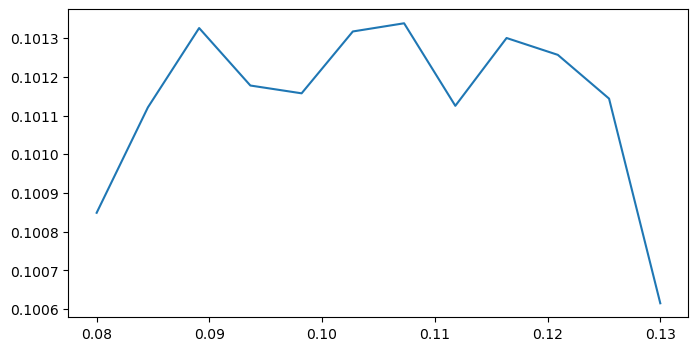

In [ ]:
plt.plot(xs, f1_macros2);

F1-micro

In [ ]:
xs = torch.linspace(0.05, 0.95, 30)
f1_micros = [compute_met(F1ScoreMulti(thresh=i, average='micro'), learn) for i in xs] 
plt.plot(xs, f1_micros)

In [ ]:
torch.save((f1_micros, xs), 'tmp/f1_micros.pkl')

In [ ]:
f1_micros, xs = torch.load('tmp/f1_micros.pkl')

In [ ]:
max(f1_micros)

0.5942085351624651

In [ ]:
max(list(zip(f1_micros, xs)))

(0.5942085351624651, tensor(0.2983))

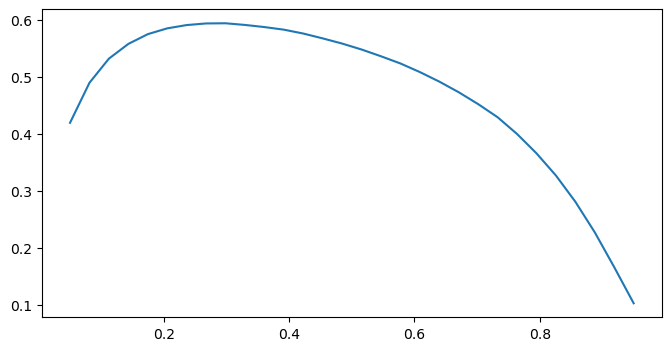

In [ ]:
plt.plot(xs, f1_micros);

ROC:

In [ ]:
from sklearn.metrics import roc_curve, auc
def auc_metrics(yhat_raw, y):
    if yhat_raw.shape[0] <= 1:
        return
    fpr = {}
    tpr = {}
    roc_auc = {}
    #get AUC for each label individually
    relevant_labels = []
    auc_labels = {}
    for i in range(y.shape[1]):
        #only if there are true positives for this label
        if y[:,i].sum() > 0:
            fpr[i], tpr[i], _ = roc_curve(y[:,i], yhat_raw[:,i])
            if len(fpr[i]) > 1 and len(tpr[i]) > 1:
                auc_score = auc(fpr[i], tpr[i])
                if not np.isnan(auc_score): 
                    auc_labels["auc_%d" % i] = auc_score
                    relevant_labels.append(i)

    #macro-AUC: just average the auc scores
    aucs = []
    for i in relevant_labels:
        aucs.append(auc_labels['auc_%d' % i])
    roc_auc['auc_macro'] = np.mean(aucs)

    #micro-AUC: just look at each individual prediction
    ymic = y.ravel()
    yhatmic = yhat_raw.ravel()
    fpr["micro"], tpr["micro"], _ = roc_curve(ymic, yhatmic) 
    roc_auc["auc_micro"] = auc(fpr["micro"], tpr["micro"])

    return roc_auc

In [ ]:
auc_metrics(preds.numpy(), targs.numpy())

{'auc_macro': 0.9007762488228775, 'auc_micro': 0.9870810261597994}

In [ ]:
auc_metrics(preds_r.numpy(), targs.numpy())

{'auc_macro': 0.8902260027903973, 'auc_micro': 0.9859859346244685}

In [ ]:
auc_metrics(np.add(preds.numpy(),preds_r.numpy()), targs.numpy())

{'auc_macro': 0.9036246766669686, 'auc_micro': 0.9880094959665954}

In [ ]:
auc_metrics(np.add(preds.numpy(),preds_r.numpy()), targs.numpy())

{'auc_macro': 0.9036246766669686, 'auc_micro': 0.9880094959665954}

Precision@k

In [ ]:
precision_at_k(preds+preds_r, targs,k=5), precision_at_k(preds+preds_r, targs,k=8), precision_at_k(preds+preds_r, targs,k=15)

(0.8403914590747331, 0.7707221233689205, 0.6167457493080268)

## Metrics MIMIC3-Top50

Load the dataloaders:

In [ ]:
dls_clas = torch.load(tmp/'mimic3-9k_dls_clas_top50.pkl', map_location=default_device())
dls_clas_r = torch.load(tmp/'mimic3-9k_dls_clas_top50_r.pkl', map_location=default_device())

In [ ]:
fname = 'mimic3-9k_top50'
fname_r = fname+'_r'
tmp = Path.cwd()/'tmp'

- make `max_len=None` during testing

In [ ]:
learn = xmltext_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.1, max_len=None, 
                                   metrics=partial(precision_at_k, k=15), path=tmp, cbs=None,
                                   pretrained=False,
                                   splitter=awd_lstm_xclas_split,
                                   running_decoder=True,
                                   plant=0.4).to_fp16()
learn_r = xmltext_classifier_learner(dls_clas_r, AWD_LSTM, drop_mult=0.1, max_len=None, 
                                     metrics=partial(precision_at_k, k=15), path=tmp, cbs=None,
                                     pretrained=False,
                                     splitter=awd_lstm_xclas_split,
                                     running_decoder=True,
                                     plant=0.4).to_fp16()  

In [ ]:
learn = learn.load(fname)
learn_r = learn_r.load(fname_r)
preds, targs = learn.get_preds()
preds_r, targs = learn_r.get_preds()

In [ ]:
class _FakeLearner: 
    def to_detach(self,b,cpu=True,gather=True):
        return to_detach(b,cpu,gather)
_fake_l = _FakeLearner()

def cpupy(t): return t.cpu().numpy() if isinstance(t, Tensor) else t
learn.model = learn.model.to('cuda:0')

In [ ]:
import warnings; warnings.filterwarnings("ignore")
def compute_met(met, learn):
    learn.model.eval()
    met.reset()
    pbar = progress_bar(learn.dls.valid)
    for i, (xb, yb) in enumerate(pbar):
        _fake_l.yb = (yb,)
        _fake_l.y = yb
        _fake_l.pred, *_ = learn.model(xb)
        _fake_l.loss = Tensor(learn.loss_func(_fake_l.pred, yb))
        met.accumulate(_fake_l)
        pbar.comment = str(met.value)
    return met.value

f1 score macro:

In [ ]:
xs = torch.linspace(0.05, 0.95, 29)
f1_macros = [compute_met(F1ScoreMulti(thresh=i, average='macro'), learn) for i in xs] 
plt.plot(xs, f1_macros)

In [ ]:
compute_met(F1ScoreMulti(thresh=0.26, average='macro'), learn)

0.6843802499273407

In [ ]:
compute_met(F1ScoreMulti(thresh=0.29, average='macro'), learn)

0.6849821106145282

f1 score micro:

In [ ]:
compute_met(F1ScoreMulti(thresh=0.2983, average='micro'), learn)

0.725605645197537

In [ ]:
compute_met(F1ScoreMulti(thresh=0.33, average='micro'), learn)

0.7273896467778237

In [ ]:
compute_met(F1ScoreMulti(thresh=0.37, average='micro'), learn)

0.7278988583828663

In [ ]:
compute_met(F1ScoreMulti(thresh=0.39, average='micro'), learn)

0.7271513070024805

AUC Metrics:

In [ ]:
from sklearn.metrics import roc_curve, auc
def auc_metrics(yhat_raw, y):
    if yhat_raw.shape[0] <= 1:
        return
    fpr = {}
    tpr = {}
    roc_auc = {}
    #get AUC for each label individually
    relevant_labels = []
    auc_labels = {}
    for i in range(y.shape[1]):
        #only if there are true positives for this label
        if y[:,i].sum() > 0:
            fpr[i], tpr[i], _ = roc_curve(y[:,i], yhat_raw[:,i])
            if len(fpr[i]) > 1 and len(tpr[i]) > 1:
                auc_score = auc(fpr[i], tpr[i])
                if not np.isnan(auc_score): 
                    auc_labels["auc_%d" % i] = auc_score
                    relevant_labels.append(i)

    #macro-AUC: just average the auc scores
    aucs = []
    for i in relevant_labels:
        aucs.append(auc_labels['auc_%d' % i])
    roc_auc['auc_macro'] = np.mean(aucs)

    #micro-AUC: just look at each individual prediction
    ymic = y.ravel()
    yhatmic = yhat_raw.ravel()
    fpr["micro"], tpr["micro"], _ = roc_curve(ymic, yhatmic) 
    roc_auc["auc_micro"] = auc(fpr["micro"], tpr["micro"])

    return roc_auc

In [ ]:
auc_metrics(preds.numpy(), targs.numpy())

{'auc_macro': 0.9246863848548884, 'auc_micro': 0.9466225882649537}

In [ ]:
auc_metrics(preds.numpy()+preds_r.numpy(), targs.numpy())

{'auc_macro': 0.9306174885742357, 'auc_micro': 0.9501452437625404}

precision@k

In [ ]:
precision_at_k(preds, targs, k=5), precision_at_k(preds, targs, k=8), precision_at_k(preds, targs, k=15)

(0.6736842105263159, 0.5508964719491035, 0.36124927703875076)

In [ ]:
precision_at_k(preds+preds_r, targs, k=5), precision_at_k(preds+preds_r, targs, k=8), precision_at_k(preds+preds_r, targs, k=15)

(0.6781954887218045, 0.5545112781954887, 0.36333140543666864)